In [144]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error


sns.set()

In [145]:
#load scaled monthly changes
monthly_scaled_changes = pd.read_csv('../data/processed/scaled_monthly_diff.csv')
monthly_scaled_changes.index = monthly_scaled_changes['time']
monthly_scaled_changes = monthly_scaled_changes.drop('time', axis=1)
monthly_scaled_changes.tail()

AdrActCnt    BlkCnt  BlkSizeByte  BlkSizeMeanByte  CapMVRVCur  \
time                                                                        
2020-10-31  -0.115866 -0.597671    -0.183876         0.029885    0.055306   
2020-11-30   0.247065  0.479948     0.193284         0.021492    0.175700   
2020-12-31   0.134429  0.086934     0.092833         0.056472    0.116448   
2021-01-31   0.217782  0.219146     0.130771         0.046818    0.153919   
2021-02-28   0.024242 -3.864936    -1.427537        -0.000026    0.085350   

            CapMrktCurUSD  CapRealUSD  DiffMean  FeeMeanNtv  FeeMeanUSD  ...  \
time                                                                     ...   
2020-10-31       0.203861    0.055194  0.264025    0.203382    0.533942  ...   
2020-11-30       0.773848    0.254945 -0.371647   -0.009503    0.331112  ...   
2020-12-31       0.865326    0.413359  0.239179   -0.109371    0.246313  ...   
2021-01-31       2.071482    1.152395  0.217581    0.025902    1.183264  ...   
2021-02-28       1.420052    0.646411  0.199070    0.178660    2.046219  ...   

            TxTfrValMeanUSD  TxTfrValMedNtv  TxTfrValMedUSD  TxTfrValNtv  \
time                                                                       
2020-10-31         0.253729       -0.000197        0.101731     0.022329   
2020-11-30         0.560609       -0.000560        0.303117    -0.002575   
2020-12-31         0.564573       -0.000488        0.149764     0.015351   
2021-01-31         1.408853       -0.000571        0.393662     0.022072   
2021-02-28         0.411214       -0.000144        0.361876    -0.235231   

            TxTfrValUSD  VtyDayRet180d  VtyDayRet30d  VtyDayRet60d  \
time                                                                 
2020-10-31     0.227189      -0.356987     -0.360987     -0.148578   
2020-11-30     0.571422      -0.087946      0.374314      0.005101   
2020-12-31     0.799040       0.050865      0.289843      0.327762   
2021-01-31     1.857506       0.232483      0.369318      0.343490   
2021-02-28    -1.765276       0.182950      0.345192      0.281175   

            block_height  halving_period  
time                                      
2020-10-31      0.024154             0.0  
2020-11-30      0.025677             0.0  
2020-12-31      0.025953             0.0  
2021-01-31      0.026649             0.0  
2021-02-28      0.014380             0.0  

[5 rows x 44 columns]

count    127.000000
mean       0.054771
std        0.286641
min       -0.559203
25%       -0.002263
50%        0.000302
75%        0.015283
max        2.041442
Name: PriceUSD, dtype: float64


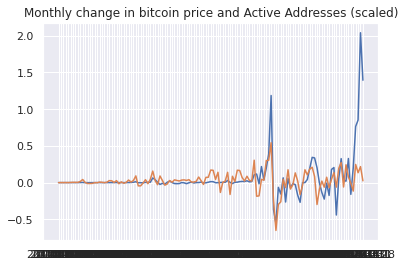

In [146]:
print(monthly_scaled_changes['PriceUSD'].describe())

plt.plot(monthly_scaled_changes['PriceUSD'])
plt.plot(monthly_scaled_changes['AdrActCnt'])
plt.title('Monthly change in bitcoin price and Active Addresses (scaled)')
#plt.locator_params(axis='x', nbins=2) 
plt.show()

In [147]:
! pip install --user tscv

In [148]:
#import package to perform train-test split
from tscv import GapLeavePOut, GapKFold, GapWalkForward, gap_train_test_split

In [149]:
#train-test split using varios methods from the tscv package

#Gap leave p out
p= round(len(monthly_scaled_changes) * 0.2)
gap_before = round(p * 0.2)
gap_after = p - gap_before

cv_pout = GapLeavePOut(p=p, gap_before=gap_before, gap_after=gap_after)
pout_split = cv_pout.split(monthly_scaled_changes)
pout_split




<generator object GapCrossValidator.split at 0x7fa7e433e7b0>

In [150]:
#Gap k fold
cv_gapkfold = GapKFold(n_splits=5, gap_before=gap_before, gap_after=gap_after)
gapkfold_split = cv_gapkfold.split(monthly_scaled_changes)
gapkfold_split

<generator object GapCrossValidator.split at 0x7fa7dff5e2e0>

In [151]:
#Gap kwalk forward
test_size= 12
gap_size = 1
print(test_size)
print(gap_size)
cv_gapwf = GapWalkForward(n_splits=5, gap_size=gap_size, test_size=test_size)
gapfw_split = cv_gapwf.split(monthly_scaled_changes)
gapfw_split

12
1


<generator object GapWalkForward.split at 0x7fa7e4c68820>

In [152]:
#Gap train-test split

X = monthly_scaled_changes.drop('PriceUSD', axis=1)
y = monthly_scaled_changes['PriceUSD']

X_train, X_hold, y_train, y_hold = gap_train_test_split(X, y, test_size=test_size, gap_size=gap_size) 

X_train, X_test, y_train, y_test = gap_train_test_split(X_train, y_train, test_size=6, gap_size=gap_size)


/home/julio/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [153]:
y_test

time
2019-08-31   -0.004942
2019-09-30   -0.133833
2019-10-31   -0.224877
2019-11-30   -0.007597
2019-12-31   -0.174991
2020-01-31    0.179160
Name: PriceUSD, dtype: float64

In [154]:
X_train.tail()

AdrActCnt    BlkCnt  BlkSizeByte  BlkSizeMeanByte  CapMVRVCur  \
time                                                                        
2019-02-28   0.174503 -0.724449     0.006181         0.216980    0.006161   
2019-03-31   0.105495  0.769727     0.158038        -0.066950    0.024370   
2019-04-30   0.183877 -0.383958     0.292680         0.405266    0.096231   
2019-05-31   0.209202  0.693660     0.252106         0.018825    0.152546   
2019-06-30   0.082362 -0.365847    -0.140237        -0.019976    0.116519   

            CapMrktCurUSD  CapRealUSD  DiffMean  FeeMeanNtv  FeeMeanUSD  ...  \
time                                                                     ...   
2019-02-28       0.001757   -0.027963  0.037347    0.019918    0.012808  ...   
2019-03-31       0.042178   -0.011201  0.029973    0.035802    0.028054  ...   
2019-04-30       0.189737    0.015095  0.039625    0.227462    0.225350  ...   
2019-05-31       0.333657    0.056739  0.054863    0.220429    0.434539  ...   
2019-06-30       0.328470    0.116591  0.140949   -0.045415    0.112188  ...   

            TxTfrValMeanUSD  TxTfrValMedNtv  TxTfrValMedUSD  TxTfrValNtv  \
time                                                                       
2019-02-28        -0.038386        0.000178        0.038419    -0.035499   
2019-03-31         0.082176       -0.000368       -0.007106     0.083816   
2019-04-30         0.288205       -0.000634        0.139778     0.105638   
2019-05-31         0.290431       -0.000626        0.228345    -0.002675   
2019-06-30         0.830396       -0.000277        0.260078     0.143011   

            TxTfrValUSD  VtyDayRet180d  VtyDayRet30d  VtyDayRet60d  \
time                                                                 
2019-02-28    -0.033876      -0.061151     -0.611680     -0.547460   
2019-03-31     0.126791      -0.011875     -0.021991     -0.362533   
2019-04-30     0.356563       0.098279      0.423022      0.218867   
2019-05-31     0.424104       0.042591      0.158269      0.278780   
2019-06-30     0.791722      -0.096396      0.250122      0.234069   

            block_height  halving_period  
time                                      
2019-02-28      0.023717             0.0  
2019-03-31      0.026160             0.0  
2019-04-30      0.024941             0.0  
2019-05-31      0.027143             0.0  
2019-06-30      0.025982             0.0  

[5 rows x 43 columns]

In [155]:
X_test

AdrActCnt    BlkCnt  BlkSizeByte  BlkSizeMeanByte  CapMVRVCur  \
time                                                                        
2019-08-31  -0.090182 -0.170246    -0.133203        -0.085558   -0.040844   
2019-09-30   0.020633 -0.074256    -0.092400        -0.063435   -0.068113   
2019-10-31  -0.062346 -0.201035    -0.026372         0.025132   -0.084984   
2019-11-30   0.073262 -0.503492    -0.032001         0.123786   -0.004595   
2019-12-31  -0.069602  0.646571    -0.034390        -0.221303   -0.060656   
2020-01-31   0.044172  0.242690     0.058064        -0.011734    0.069062   

            CapMrktCurUSD  CapRealUSD  DiffMean  FeeMeanNtv  FeeMeanUSD  ...  \
time                                                                     ...   
2019-08-31       0.000683    0.115440  0.208959   -0.090779   -0.160992  ...   
2019-09-30      -0.125240    0.056792  0.277302   -0.058753   -0.127651  ...   
2019-10-31      -0.215165   -0.000852  0.275399   -0.005360   -0.039133  ...   
2019-11-30      -0.003634    0.012523 -0.015241    0.019081    0.023751  ...   
2019-12-31      -0.168279   -0.024873 -0.018050   -0.057632   -0.099416  ...   
2020-01-31       0.180875    0.010604  0.257094   -0.005129    0.013647  ...   

            TxTfrValMeanUSD  TxTfrValMedNtv  TxTfrValMedUSD  TxTfrValNtv  \
time                                                                       
2019-08-31        -0.782267       -0.000013       -0.006336    -0.259417   
2019-09-30        -0.037058        0.000249        0.009112     0.014202   
2019-10-31        -0.255637        0.000258       -0.109828    -0.029692   
2019-11-30         0.119320        0.000066        0.018788     0.033853   
2019-12-31        -0.065094        0.000066       -0.176760     0.040464   
2020-01-31         0.130357       -0.000261        0.096889    -0.009257   

            TxTfrValUSD  VtyDayRet180d  VtyDayRet30d  VtyDayRet60d  \
time                                                                 
2019-08-31    -0.808534       0.112893     -0.724754     -0.054947   
2019-09-30    -0.068424       0.031228     -0.490961     -0.657360   
2019-10-31    -0.237000      -0.007406      0.090934     -0.204691   
2019-11-30     0.065382      -0.050879      0.169054      0.149654   
2019-12-31    -0.043467      -0.128443     -0.314715     -0.087497   
2020-01-31     0.141280      -0.295031      0.066818     -0.128859   

            block_height  halving_period  
time                                      
2019-08-31      0.026885             0.0  
2019-09-30      0.026649             0.0  
2019-10-31      0.026011             0.0  
2019-11-30      0.024412             0.0  
2019-12-31      0.026465             0.0  
2020-01-31      0.027235             0.0  

[6 rows x 43 columns]

In [156]:
y_train

time
2010-08-31   -1.986036e-07
2010-09-30   -4.302590e-07
2010-10-31    7.536975e-06
2010-11-30    2.416807e-05
2010-12-31   -2.495503e-06
                  ...     
2019-02-28   -5.045996e-06
2019-03-31    4.228132e-02
2019-04-30    1.956118e-01
2019-05-31    3.435942e-01
2019-06-30    3.360694e-01
Name: PriceUSD, Length: 107, dtype: float64

In [157]:
#Creating DataFrames of train data.

#Choosing the variables from X_train
X_train_1 = X_train[['AdrActCnt', 'TxCnt', 'IssTotNtv', 'HashRate']]
X_train_1.tail()

train_df = pd.concat([X_train_1, y_train], axis=1)
train_df.tail()

AdrActCnt     TxCnt  IssTotNtv  HashRate  PriceUSD
time                                                          
2019-02-28   0.174503  0.010249  -0.064664  0.047097 -0.000005
2019-03-31   0.105495  0.053552   0.068706  0.026533  0.042281
2019-04-30   0.183877  0.415428  -0.034272  0.023508  0.195612
2019-05-31   0.209202  0.136157   0.061916  0.114329  0.343594
2019-06-30   0.082362 -0.275243  -0.032656  0.134253  0.336069

In [158]:
#VAR model
model = VAR(train_df)
results = model.fit(ic='aic')
model_max_lags = results.k_ar
print('model max lags: {}'.format(model_max_lags))
#print(results.mse(1))
print(results.summary())

/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


model max lags: 12
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:27:49
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -21.8970
Nobs:                     95.0000    HQIC:                  -26.7831
Log likelihood:           1060.58    FPE:                2.81166e-13
AIC:                     -30.0963    Det(Omega_mle):     2.35482e-14
--------------------------------------------------------------------
Results for equation AdrActCnt
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.034928         0.023548            1.483           0.138
L1.AdrActCnt          0.474404         0.350581            1.353           0.176
L1.TxCnt             -0.269924       

In [159]:
#results.params['PriceUSD']

r2: 0.9322830513076763
Explained variance: 0.9322830513076763
MAE: 0.03208372257156485
MSE: 0.001848636385317742
RMSE: 0.04299577171441096


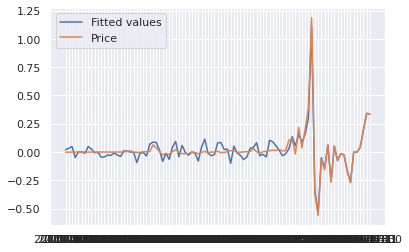

In [160]:
#metrics

PriceUSD_pred = results.fittedvalues['PriceUSD']
PriceUSD_resid = results.resid['PriceUSD']
PriceUSD_train_wo_lags = train_df['PriceUSD'].iloc[model_max_lags:]
#print(y_train, PriceUSD_pred)

#r squared
PriceUSD_r2 = r2_score(PriceUSD_train_wo_lags, PriceUSD_pred)

#explained variance
PriceUSD_expl_var = explained_variance_score(PriceUSD_train_wo_lags, PriceUSD_pred)

#MAE
PriceUSD_mae = mean_absolute_error(PriceUSD_train_wo_lags, PriceUSD_pred)

#MSE
PriceUSD_mse = mean_squared_error(PriceUSD_train_wo_lags, PriceUSD_pred)

print('r2: {}'.format(PriceUSD_r2))
print('Explained variance: {}'.format(PriceUSD_expl_var))
print('MAE: {}'.format(PriceUSD_mae))
print('MSE: {}'.format(PriceUSD_mse))
print('RMSE: {}'.format(np.sqrt(PriceUSD_mse)))

plt.plot(PriceUSD_pred, label='Fitted values')
plt.plot(PriceUSD_train_wo_lags, label='Price')
plt.legend(loc='best')
plt.show()

In [161]:
def get_best_VAR_model(data):
    '''calculates a VAR model and various scores for Price_USD trying all parameters in ic_list and trend_list'''
    ic_list = ['aic', 'fpe', 'hqic', 'bic']
    trend_list = ['c', 'ct', 'ctt', 'nc', 'n']
    scores_df = pd.DataFrame([], index=['r2', 'explained variance', 'mae', 'mse', 'rmse', 'max lags'])
    #print(type(scores_df))
    score_list = []
    
    var_model = VAR(data)
    for ic in ic_list:
        for trend in trend_list:
            results = var_model.fit(ic=ic, trend=trend)
            model_max_lags = results.k_ar
            y_pred = results.fittedvalues['PriceUSD']
            y_true = train_df['PriceUSD'].iloc[model_max_lags:]
            
            #scores
            r2 = r2_score(y_true, y_pred)
            exp_var = explained_variance_score(y_true, y_pred)
            mae = mean_absolute_error(y_true, y_pred)
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            column_name = ic + '_' + trend
            scores_df[column_name] = pd.Series([r2, exp_var, mae, mse, rmse, model_max_lags]).values
            #print(type(scores))
            #print(len(scores))
            #score_list.append(scores)
                        
    
    scores_df = scores_df.T
    #print(type(r2))
    #print(scores)
    return scores_df

#different variables to run the model with
TxIssHash = ['TxCnt', 'IssTotNtv', 'HashRate']
AdrIssHash = ['AdrActCnt', 'IssTotNtv', 'HashRate']
columns_adrTx = ['AdrActCnt', 'TxCnt', 'IssTotNtv', 'HashRate']
AdrTxIss = ['AdrActCnt', 'TxCnt', 'IssTotNtv']


#1st VAR model
X_train_adrTx = X_train[columns_adrTx]
train_df = pd.concat([X_train_adrTx, y_train], axis=1)

scores_VAR1 = get_best_VAR_model(train_df)
print(scores_VAR1)


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


                r2  explained variance       mae       mse      rmse  max lags
aic_c     0.932283            0.932283  0.032084  0.001849  0.042996      12.0
aic_ct    0.932291            0.932291  0.032039  0.001848  0.042993      12.0
aic_ctt   0.933749            0.933749  0.031390  0.001809  0.042528      12.0
aic_nc    0.930670            0.930889  0.032794  0.001893  0.043505      12.0
aic_n     0.930670            0.930889  0.032794  0.001893  0.043505      12.0
fpe_c     0.932283            0.932283  0.032084  0.001849  0.042996      12.0
fpe_ct    0.932291            0.932291  0.032039  0.001848  0.042993      12.0
fpe_ctt   0.933749            0.933749  0.031390  0.001809  0.042528      12.0
fpe_nc    0.930670            0.930889  0.032794  0.001893  0.043505      12.0
fpe_n     0.930670            0.930889  0.032794  0.001893  0.043505      12.0
hqic_c    0.932283            0.932283  0.032084  0.001849  0.042996      12.0
hqic_ct   0.932291            0.932291  0.032039  0.

In [162]:
#2nd VAR model
X_train_TxIssHash = X_train[TxIssHash]
train_df = pd.concat([X_train_TxIssHash, y_train], axis=1)
#print(train_df.tail())

scores_VAR2 = get_best_VAR_model(train_df)
print(scores_VAR2)

/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


                r2  explained variance       mae       mse      rmse  max lags
aic_c     0.864411            0.864411  0.041346  0.003702  0.060840      12.0
aic_ct    0.865775            0.865775  0.040850  0.003664  0.060533      12.0
aic_ctt   0.870994            0.870994  0.040144  0.003522  0.059345      12.0
aic_nc    0.859212            0.860181  0.041258  0.003843  0.061995      12.0
aic_n     0.859212            0.860181  0.041258  0.003843  0.061995      12.0
fpe_c     0.864411            0.864411  0.041346  0.003702  0.060840      12.0
fpe_ct    0.865775            0.865775  0.040850  0.003664  0.060533      12.0
fpe_ctt   0.870994            0.870994  0.040144  0.003522  0.059345      12.0
fpe_nc    0.859212            0.860181  0.041258  0.003843  0.061995      12.0
fpe_n     0.859212            0.860181  0.041258  0.003843  0.061995      12.0
hqic_c    0.832913            0.832913  0.045945  0.004514  0.067189      11.0
hqic_ct   0.839860            0.839860  0.044117  0.

In [163]:
#3rd VAR model
X_train_AdrIssHash = X_train[AdrIssHash]
train_df = pd.concat([X_train_AdrIssHash, y_train], axis=1)
#print(train_df.tail())

scores_VAR3 = get_best_VAR_model(train_df)
print(scores_VAR3)

/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


                r2  explained variance       mae       mse      rmse  max lags
aic_c     0.886470            0.886470  0.040611  0.003099  0.055671      12.0
aic_ct    0.887048            0.887048  0.040363  0.003084  0.055530      12.0
aic_ctt   0.895860            0.895860  0.039469  0.002843  0.053319      12.0
aic_nc    0.885962            0.886046  0.040854  0.003113  0.055796      12.0
aic_n     0.885962            0.886046  0.040854  0.003113  0.055796      12.0
fpe_c     0.886470            0.886470  0.040611  0.003099  0.055671      12.0
fpe_ct    0.887048            0.887048  0.040363  0.003084  0.055530      12.0
fpe_ctt   0.895860            0.895860  0.039469  0.002843  0.053319      12.0
fpe_nc    0.885962            0.886046  0.040854  0.003113  0.055796      12.0
fpe_n     0.885962            0.886046  0.040854  0.003113  0.055796      12.0
hqic_c    0.886470            0.886470  0.040611  0.003099  0.055671      12.0
hqic_ct   0.887048            0.887048  0.040363  0.

In [164]:
#4th VAR model
X_train_AdrTxIss = X_train[AdrTxIss]
train_df = pd.concat([X_train_AdrTxIss, y_train], axis=1)
#print(train_df.tail())

scores_VAR4 = get_best_VAR_model(train_df)
print(scores_VAR4)

/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


                r2  explained variance       mae       mse      rmse  max lags
aic_c     0.766878            0.766878  0.057985  0.006364  0.079775      12.0
aic_ct    0.797057            0.797057  0.051420  0.005540  0.074433      12.0
aic_ctt   0.815286            0.815286  0.049737  0.005043  0.071011      12.0
aic_nc    0.739395            0.745375  0.058979  0.007114  0.084347      12.0
aic_n     0.739395            0.745375  0.058979  0.007114  0.084347      12.0
fpe_c     0.766878            0.766878  0.057985  0.006364  0.079775      12.0
fpe_ct    0.797057            0.797057  0.051420  0.005540  0.074433      12.0
fpe_ctt   0.815286            0.815286  0.049737  0.005043  0.071011      12.0
fpe_nc    0.739395            0.745375  0.058979  0.007114  0.084347      12.0
fpe_n     0.739395            0.745375  0.058979  0.007114  0.084347      12.0
hqic_c    0.136351            0.136351  0.065386  0.021350  0.146116       2.0
hqic_ct   0.143776            0.143776  0.065946  0.

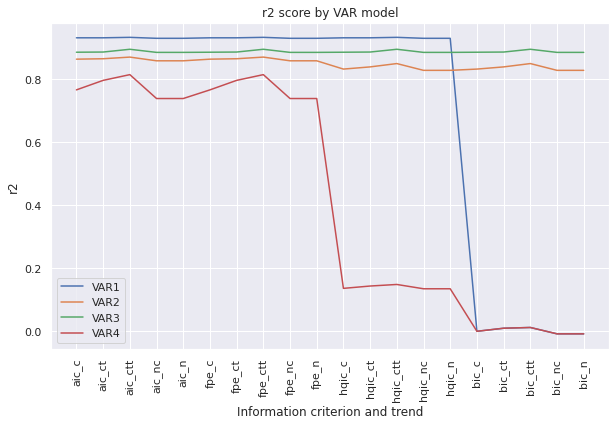

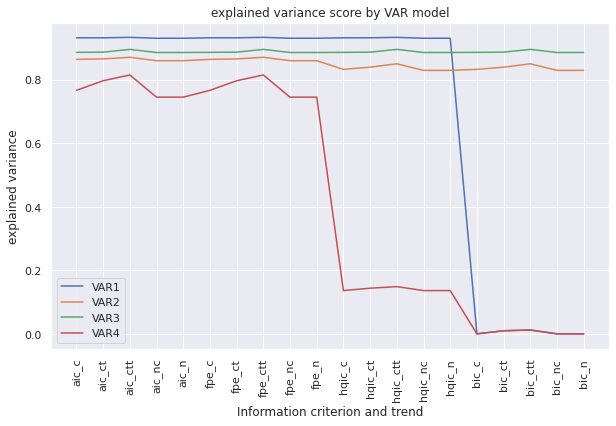

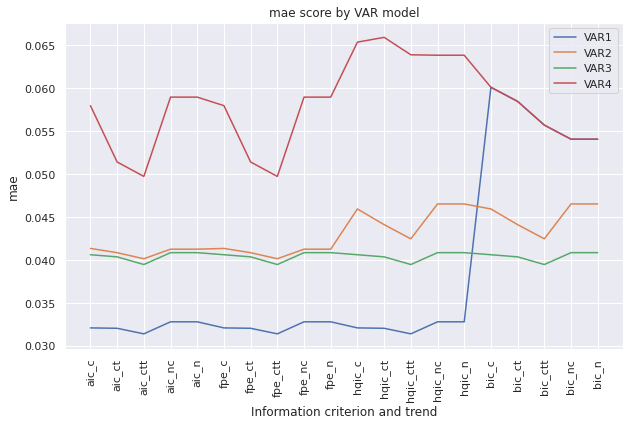

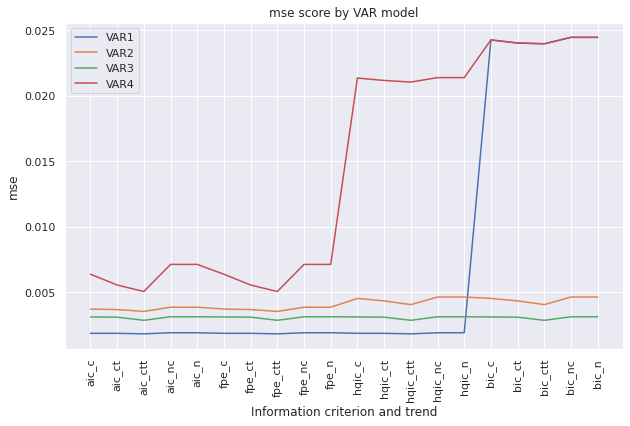

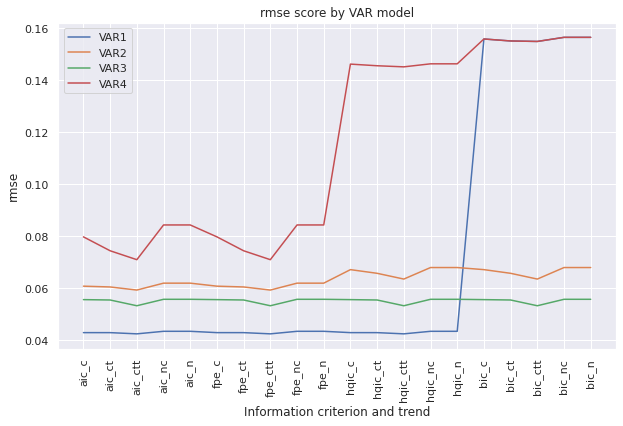

In [165]:
#plot scores for the PriceUSD ecuation in the models

scores_to_plot = ['r2', 'explained variance', 'mae', 'mse', 'rmse']

for score in scores_to_plot:
    plt.figure(figsize=(10,6))
    plt.plot(scores_VAR1[score], label='VAR1')
    plt.plot(scores_VAR2[score], label='VAR2')
    plt.plot(scores_VAR3[score], label='VAR3')
    plt.plot(scores_VAR4[score], label='VAR4')
    plt.legend(loc='best')
    plt.title('{} score by VAR model'.format(score))
    plt.ylabel(score)
    plt.xlabel('Information criterion and trend')
    plt.xticks(rotation=90)

plt.show()

#under all metrics VAR1 model performs best on the training set.

In [166]:
#Combination of hyperparameters that performs best in VAR1 model.
print('r2: {}'.format(scores_VAR1['r2'].idxmax(axis=0, skipna=True)))
print('explained variance: {}'.format(scores_VAR1['explained variance'].idxmax(axis=0, skipna=True)))
print('mae: {}'.format(scores_VAR1['mae'].idxmin(axis=0, skipna=True)))
print('mse: {}'.format(scores_VAR1['mse'].idxmin(axis=0, skipna=True)))
print('rmse: {}'.format(scores_VAR1['rmse'].idxmin(axis=0, skipna=True)))

#VAR1 using aic as information criterion and ctt as trend is the one with most of the best scores
#on the training data.

r2: aic_ctt
explained variance: aic_ctt
mae: aic_ctt
mse: aic_ctt
rmse: aic_ctt


In [167]:
#Training and predicting with the VAR1 model.
best_model_df_train = pd.concat([X_train[columns_adrTx], y_train], axis=1)
best_model = VAR(best_model_df_train)
best_model_results = best_model.fit(ic='aic', trend='ctt')
best_model_max_lags = best_model_results.k_ar
print('model max lags: {}'.format(best_model_max_lags))
print(best_model_results.summary())

model max lags: 12
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:27:57
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -21.6210
Nobs:                     95.0000    HQIC:                  -26.6673
Log likelihood:           1070.24    FPE:                3.31091e-13
AIC:                     -30.0891    Det(Omega_mle):     2.60184e-14
--------------------------------------------------------------------
Results for equation AdrActCnt
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.016683         0.068619            0.243           0.808
trend                 0.000238         0.003250            0.073           0.942
trend**2              0.000033       

/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


r2: 0.9337493095002386
Explained variance: 0.9337493095002386
MAE: 0.03139045707326088
MSE: 0.0018086083229583976
RMSE: 0.042527735925609746


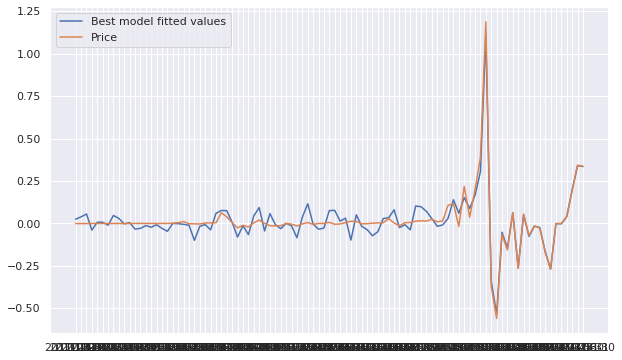

In [168]:
best_model_PriceUSD_pred = best_model_results.fittedvalues['PriceUSD']
PriceUSD_df_train_wo_lags = best_model_df_train['PriceUSD'].iloc[best_model_max_lags:]
#print(y_train, PriceUSD_pred)

#r squared
PriceUSD_r2_best_model = r2_score(PriceUSD_df_train_wo_lags, best_model_PriceUSD_pred)

#explained variance
PriceUSD_expl_var_best_model = explained_variance_score(PriceUSD_df_train_wo_lags, best_model_PriceUSD_pred)

#MAE
PriceUSD_mae_best_model = mean_absolute_error(PriceUSD_df_train_wo_lags, best_model_PriceUSD_pred)

#MSE
PriceUSD_mse_best_model = mean_squared_error(PriceUSD_df_train_wo_lags, best_model_PriceUSD_pred)

print('r2: {}'.format(PriceUSD_r2_best_model))
print('Explained variance: {}'.format(PriceUSD_expl_var_best_model))
print('MAE: {}'.format(PriceUSD_mae_best_model))
print('MSE: {}'.format(PriceUSD_mse_best_model))
print('RMSE: {}'.format(np.sqrt(PriceUSD_mse_best_model)))

plt.figure(figsize=(10,6))
plt.plot(best_model_PriceUSD_pred, label='Best model fitted values')
plt.plot(PriceUSD_df_train_wo_lags, label='Price')
plt.legend(loc='best')
plt.show()

[[  5.48536172   9.02387684   4.284186     0.41914151  11.9499858 ]
 [  2.87637816  -1.21091942 -11.69096221   1.11810703  -2.10761321]
 [ -3.53068954  -2.69286874  -7.27893509   1.31801023  -0.18314572]
 [ -9.38504256 -13.27457944 -11.33437773   0.81659012 -15.51756365]
 [ -8.90892298  -1.83436303  11.38543739   0.0475891   10.95664586]
 [  3.29291237   2.10964233   8.90374904   0.3076682   -0.39501449]]
[ 11.9499858   -2.10761321  -0.18314572 -15.51756365  10.95664586
  -0.39501449]


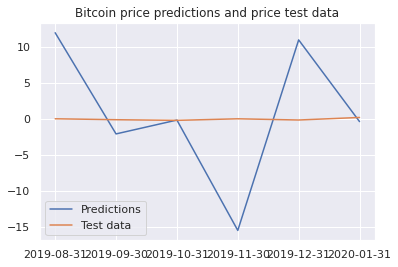

In [169]:
#predict using X_test
steps = len(y_test)
y_pred = best_model_results.forecast(y = best_model_df_train.values[-best_model_max_lags:], steps=steps)
print(y_pred)
PriceUSD_pred = y_pred[:,len(best_model_df_train.columns) - 1] 
print(PriceUSD_pred)

y_test = y_test.iloc[0:steps]

plt.plot(PriceUSD_pred, label='Predictions')
plt.plot(y_test, label='Test data')
plt.title('Bitcoin price predictions and price test data')
plt.legend(loc='best')
plt.show()

In [170]:
#test scores
r2_test = r2_score(y_test, PriceUSD_pred)
exp_var_test = explained_variance_score(y_test, PriceUSD_pred)
mae_test = mean_absolute_error(y_test, PriceUSD_pred)
mse_test = mean_squared_error(y_test, PriceUSD_pred)
rmse_test = np.sqrt(mse_test)

print(r2_test, exp_var_test, mae_test, mse_test, rmse_test)

-4700.29517984122 -4660.922135976699 6.864369538388726 85.26998989099506 9.234175106147546


In [171]:
#function to train and test model
def train_test_model(training_data, test_data, ic, trend, var_to_predict):
    '''Fits and predicts a VAR model, shows the scores and plots the results'''
    
    #fit model
    train_df = training_data
    model = VAR(train_df)
    results = model.fit(ic=ic, trend=trend)
    model_lags = results.k_ar
    
    #Training scores
    model_pred = results.fittedvalues[var_to_predict]
    var_to_predict_wo_lags = train_df[var_to_predict].iloc[model_lags:]
    #print(model_pred, var_to_predict_wo_lags)

    #r squared
    r2_train = r2_score(var_to_predict_wo_lags, model_pred)
    #explained variance
    expl_var_train = explained_variance_score(var_to_predict_wo_lags, model_pred)
    #MAE
    mae_train = mean_absolute_error(var_to_predict_wo_lags, model_pred)
    #MSE
    mse_train = mean_squared_error(var_to_predict_wo_lags, model_pred)
    #RMSE
    rmse_train = np.sqrt(mse_train)
    
    print('--------------------------------------------')
    print('Training set scores')
    print('r2: {}'.format(r2_train))
    print('Explained variance: {}'.format(expl_var_train))
    print('MAE: {}'.format(mae_train))
    print('MSE: {}'.format(mse_train))
    print('RMSE: {}'.format(rmse_train))
    
    
    #plot training set and fitted values
    print('--------------------------------------------')
    plt.figure(figsize=(10,6))
    plt.title('Bitcoin price model fit and price training data')
    plt.plot(model_pred, label='Model fitted values')
    plt.plot(var_to_predict_wo_lags, label='Price')
    plt.legend(loc='best')
    plt.show()
    
    #training model summary
    print('--------------------------------------------')
    print('model max lags: {}'.format(model_lags))
    print(results.summary())
    
    #Model prediction
    steps = len(test_data)
    y_pred = results.forecast(y = train_df.values[-model_lags:], steps=steps)
    #print(y_pred)
    PriceUSD_pred = y_pred[:,len(train_df.columns) - 1] 
    #print(PriceUSD_pred)
    y_test = test_data.iloc[0:steps]
    
    #Testing scores
    #r squared
    r2_test = r2_score(y_test, PriceUSD_pred)
    #explained variance
    expl_var_test = explained_variance_score(y_test, PriceUSD_pred)
    #MAE
    mae_test = mean_absolute_error(y_test, PriceUSD_pred)
    #MSE
    mse_test = mean_squared_error(y_test, PriceUSD_pred)
    #RMSE
    rmse_test = np.sqrt(mse_test)
    
    print('--------------------------------------------')
    print('Test set scores')
    print('r2: {}'.format(r2_test))
    print('Explained variance: {}'.format(expl_var_test))
    print('MAE: {}'.format(mae_test))
    print('MSE: {}'.format(mse_test))
    print('RMSE: {}'.format(rmse_test))
    
    #Plot test and prediction
    plt.figure(figsize=(10,6))
    plt.plot(PriceUSD_pred, label='Predictions')
    plt.plot(y_test, label='Test data')
    plt.title('Bitcoin price predictions and price test data')
    plt.legend(loc='best')
    plt.show()
    
    return results
    

/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


--------------------------------------------
Training set scores
r2: 0.9337493095002386
Explained variance: 0.9337493095002386
MAE: 0.03139045707326088
MSE: 0.0018086083229583976
RMSE: 0.042527735925609746
--------------------------------------------


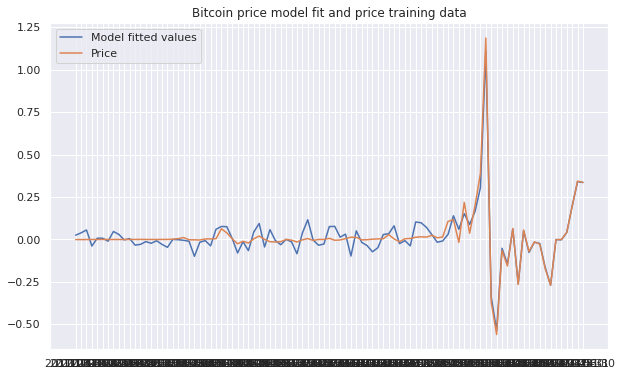

--------------------------------------------
model max lags: 12
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:28:05
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -21.6210
Nobs:                     95.0000    HQIC:                  -26.6673
Log likelihood:           1070.24    FPE:                3.31091e-13
AIC:                     -30.0891    Det(Omega_mle):     2.60184e-14
--------------------------------------------------------------------
Results for equation AdrActCnt
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.016683         0.068619            0.243           0.808
trend                 0.000238         0.003250            0.073         

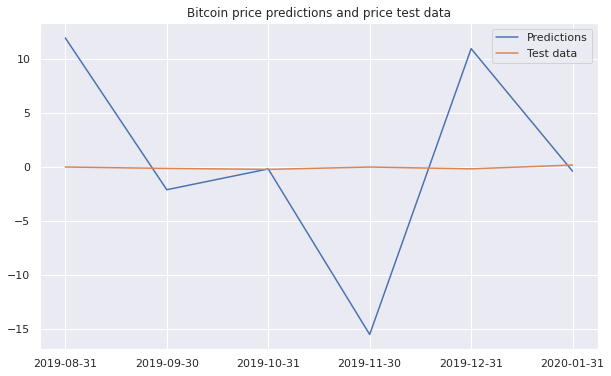

In [172]:
#training and testing with different variable combinations

X_train_columns = ['AdrActCnt', 'TxCnt', 'IssTotNtv', 'HashRate']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'ctt', 'PriceUSD'))


--------------------------------------------
Training set scores
r2: 0.7911012552560261
Explained variance: 0.7911012552560261
MAE: 0.051339350196381986
MSE: 0.005702823707186474
RMSE: 0.07551704249496582
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


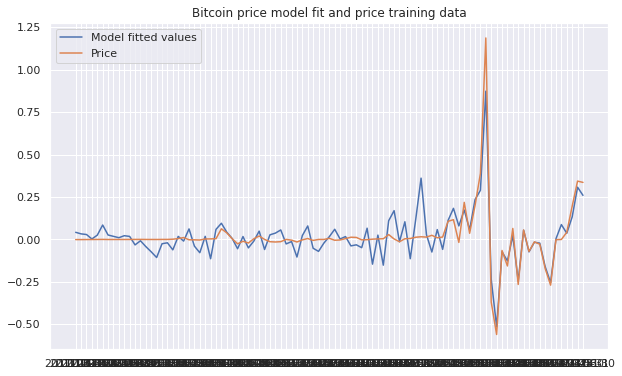

--------------------------------------------
model max lags: 12
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:28:09
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -11.7561
Nobs:                     95.0000    HQIC:                  -13.6305
Log likelihood:           420.421    FPE:                3.93910e-07
AIC:                     -14.9014    Det(Omega_mle):     1.40363e-07
--------------------------------------------------------------------
Results for equation AdrActCnt
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.024438         0.054361           -0.450           0.653
trend                 0.001692         0.002491            0.679         

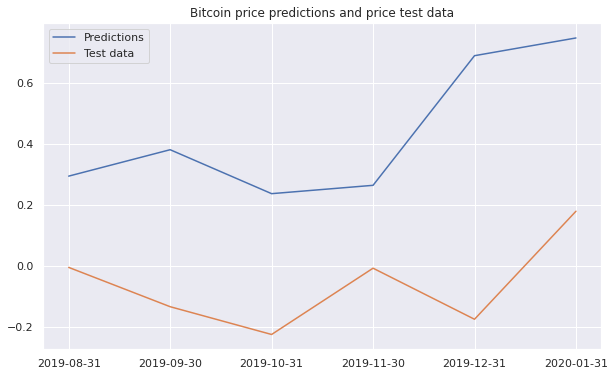

In [173]:
#training and testing with different variable combinations
#Only using AdrActCnt and TxCnt, which were the only ones that showed statistically significant coefficients.
X_train_columns = ['AdrActCnt', 'TxCnt']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'ctt', 'PriceUSD'))

#All test scores improve, but r2 at 0.09 is still very low.
#Explained variance is 0.30
#MAE, MSE and RMSE all decrease considerably.

--------------------------------------------
Training set scores
r2: 0.9214119811075261
Explained variance: 0.9214119811075261
MAE: 0.03380202207221665
MSE: 0.002145410772047002
RMSE: 0.04631857912379223
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


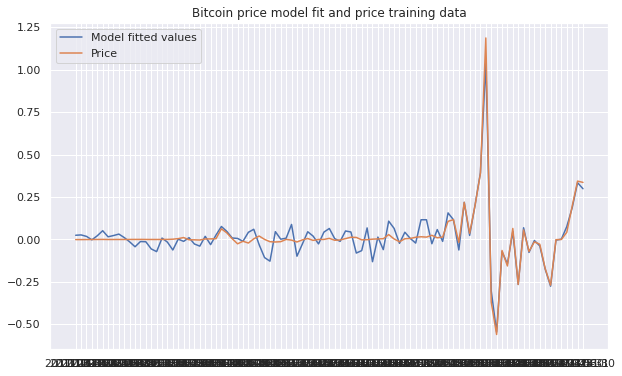

--------------------------------------------
model max lags: 12
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:28:13
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -19.2860
Nobs:                     95.0000    HQIC:                  -22.5541
Log likelihood:           841.382    FPE:                2.89009e-11
AIC:                     -24.7701    Det(Omega_mle):     5.18078e-12
--------------------------------------------------------------------
Results for equation AdrActCnt
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.013224         0.041138           -0.321           0.748
trend                  0.000543         0.001988            0.273     

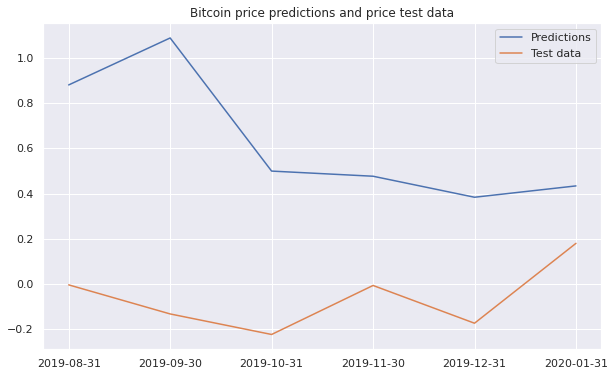

In [174]:
#training and testing with different variable combinations
#Only using AdrActCnt and TxCnt, and adding the square of AdrActCnt as per Metcalfe law hypothesis.
X_train['AdrActCnt2'] = X_train['AdrActCnt'] ** 2
X_train_columns = ['AdrActCnt', 'TxCnt', 'AdrActCnt2']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'ctt', 'PriceUSD'))

#Test scores got worse aafter including AdrActCnt2 variable.

--------------------------------------------
Training set scores
r2: 0.9698237334208321
Explained variance: 0.9698237334208321
MAE: 0.01928958175610763
MSE: 0.0008237958952456671
RMSE: 0.028701844805616016
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


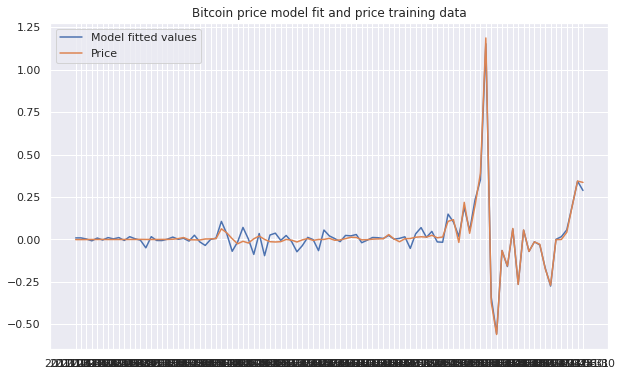

--------------------------------------------
model max lags: 12
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:28:17
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -21.2175
Nobs:                     95.0000    HQIC:                  -30.9738
Log likelihood:           1450.89    FPE:                4.03619e-13
AIC:                     -37.5892    Det(Omega_mle):     4.26125e-15
--------------------------------------------------------------------
Results for equation AdrActCnt
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.079622         0.089987            0.885           0.376
trend                      -0.002753         0.003943  

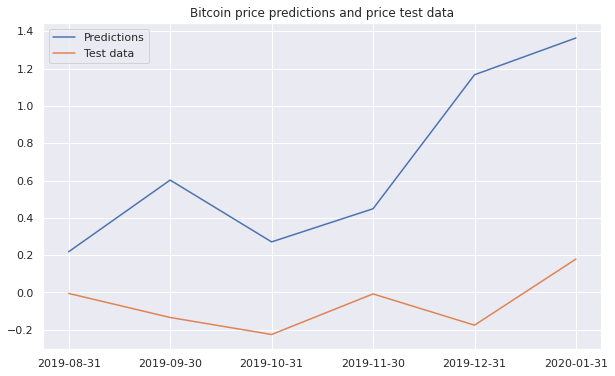

In [175]:
#training and testing with different variable combinations
#Will test adding more explanatory variables regarding transactions, as TxCnt seems to have explanatory power.
X_train_columns = ['AdrActCnt', 'TxCnt', 'TxTfrCnt', 'TxTfrValAdjNtv', 'TxTfrValMeanNtv', 'TxTfrValNtv']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'ctt', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.9067799686388619
Explained variance: 0.9067799686388619
MAE: 0.03774879711856379
MSE: 0.002544856865858697
RMSE: 0.05044657437189067
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


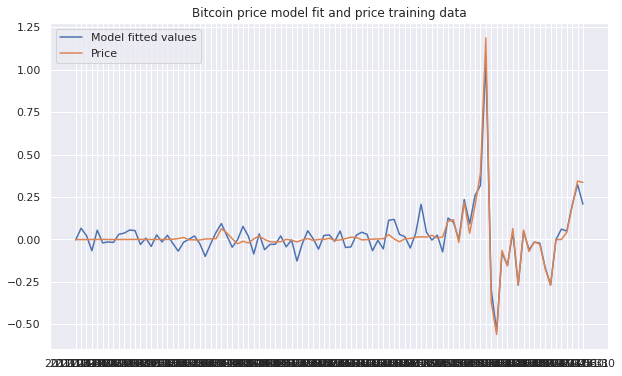

--------------------------------------------
model max lags: 12
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:28:21
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -10.0308
Nobs:                     95.0000    HQIC:                  -17.2399
Log likelihood:           692.292    FPE:                7.11231e-09
AIC:                     -22.1282    Det(Omega_mle):     2.16600e-10
--------------------------------------------------------------------
Results for equation AdrActCnt
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.026228         0.081466            0.322           0.747
trend                      -0.000756         0.003342  

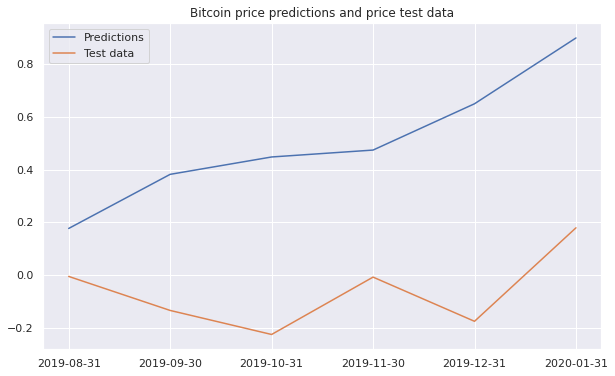

In [176]:
#training and testing with different variable combinations
#Will test adding more explanatory variables regarding transactions, as TxCnt seems to have explanatory power.
X_train_columns = ['AdrActCnt', 'TxCnt', 'TxTfrValAdjNtv', 'TxTfrValMeanNtv', 'TxTfrValNtv']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'ctt', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.9797885438316536
Explained variance: 0.9797885438316536
MAE: 0.0169060633011704
MSE: 0.0005517619147729768
RMSE: 0.023489612912369943
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


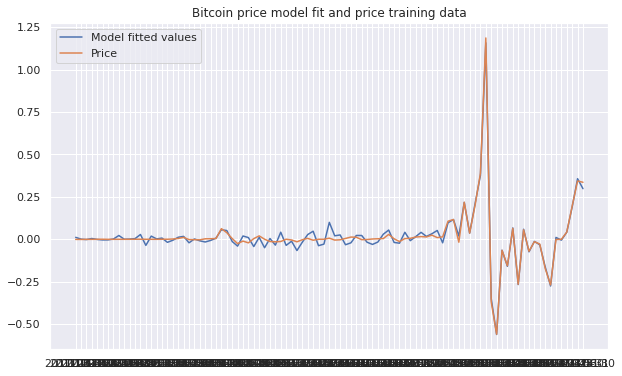

--------------------------------------------
model max lags: 12
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:28:25
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -18.7407
Nobs:                     95.0000    HQIC:                  -28.4970
Log likelihood:           1333.24    FPE:                4.80460e-12
AIC:                     -35.1124    Det(Omega_mle):     5.07251e-14
--------------------------------------------------------------------
Results for equation AdrActCnt
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.073590         0.154632           -0.476           0.634
trend                       0.002355         0.005355  

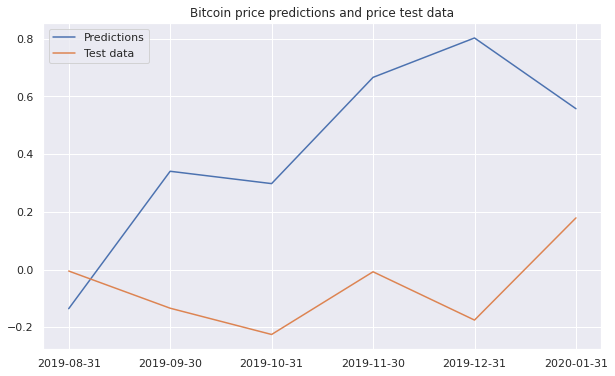

In [177]:
#training and testing with different variable combinations
#Adding issuance to the model
X_train_columns = ['AdrActCnt', 'TxCnt', 'TxTfrValAdjNtv', 'TxTfrValMeanNtv', 'TxTfrValNtv', 'IssContNtv']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'ctt', 'PriceUSD'))

#Model test scores improve after including an issuance variable (IssContNtv)

--------------------------------------------
Training set scores
r2: 0.6081644557385586
Explained variance: 0.6081644557385586
MAE: 0.06748666063466285
MSE: 0.010696900232077266
RMSE: 0.10342581994877907
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


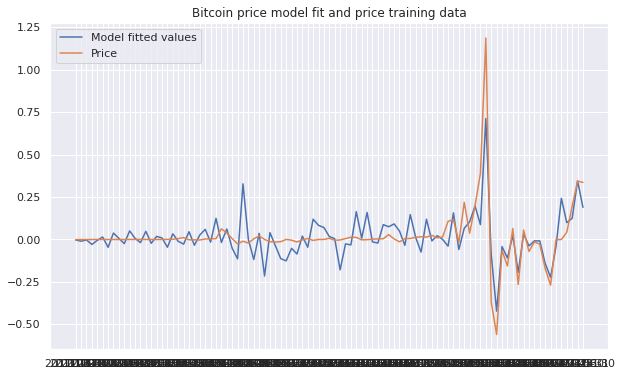

--------------------------------------------
model max lags: 12
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:28:29
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -3.06393
Nobs:                     95.0000    HQIC:                  -8.11029
Log likelihood:           188.776    FPE:                3.79466e-05
AIC:                     -11.5320    Det(Omega_mle):     2.98198e-06
--------------------------------------------------------------------
Results for equation TxTfrValAdjNtv
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -1.337926         0.544638           -2.457           0.014
trend                       0.035229         0.015

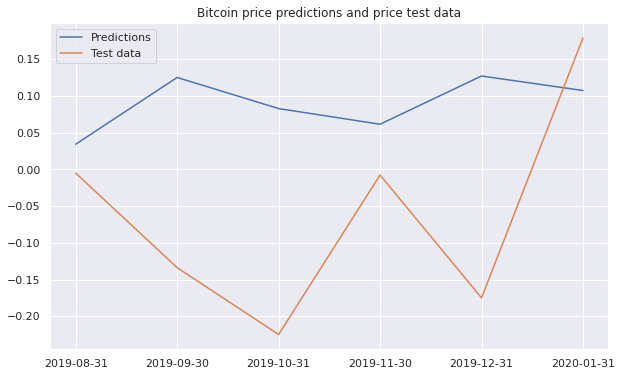

In [178]:
#training and testing with different variable combinations
#Testing the transactions per address (TxCnt/AdrActCnt) as an explanatory variable.
X_train['TxCnt/AdrActCnt'] = X_train['TxCnt'] / X_train['AdrActCnt']
X_train_columns = ['TxTfrValAdjNtv', 'TxTfrValMeanNtv', 'TxTfrValNtv', 'IssContNtv']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'ctt', 'PriceUSD'))

#All test scores get worse if the TxCnt/AdrActCnt is included.

--------------------------------------------
Training set scores
r2: 0.6377292327252473
Explained variance: 0.6377292327252473
MAE: 0.06389301668729552
MSE: 0.009889797674788045
RMSE: 0.09944746188208146
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


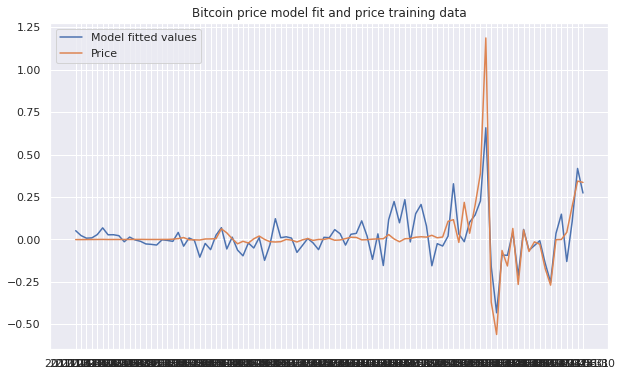

--------------------------------------------
model max lags: 12
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:28:32
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.69846
Nobs:                     95.0000    HQIC:                  -8.56355
Log likelihood:           219.033    FPE:                0.000109679
AIC:                     -9.15014    Det(Omega_mle):     6.65043e-05
--------------------------------------------------------------------
Results for equation AdrActCnt
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.030305         0.058521           -0.518           0.605
trend                 0.001750         0.002566            0.682         

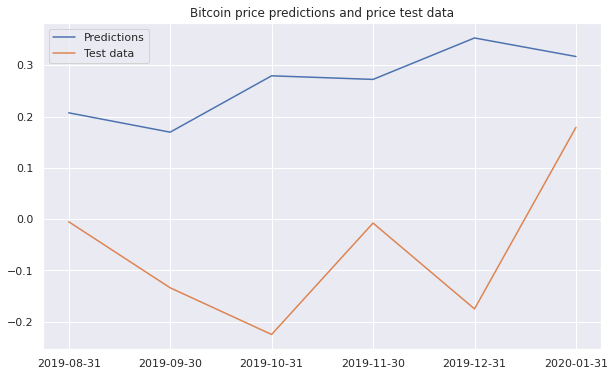

In [179]:
#training and testing with different variable combinations
#Testing only AdrActCnt as an explanatory variable.
X_train_columns = ['AdrActCnt']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'ctt', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.9818950719827633
Explained variance: 0.9818950719827633
MAE: 0.01517687270916559
MSE: 0.0004942548258973249
RMSE: 0.02223184261138345
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


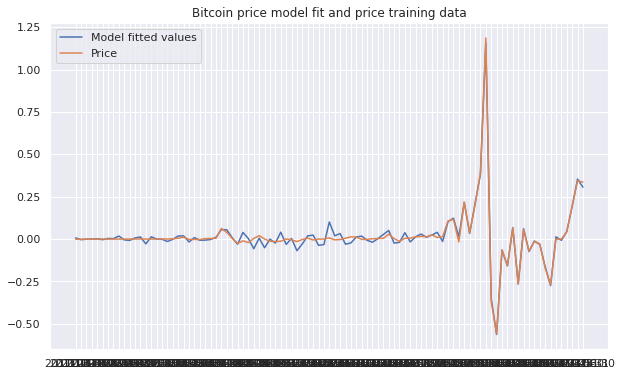

--------------------------------------------
model max lags: 12
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:28:36
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -29.7473
Nobs:                     95.0000    HQIC:                  -39.5036
Log likelihood:           1856.06    FPE:                7.97132e-17
AIC:                     -46.1190    Det(Omega_mle):     8.41581e-19
--------------------------------------------------------------------
Results for equation AdrActCnt
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.087719         0.993309            0.088           0.930
trend                      -0.000556         0.018027  

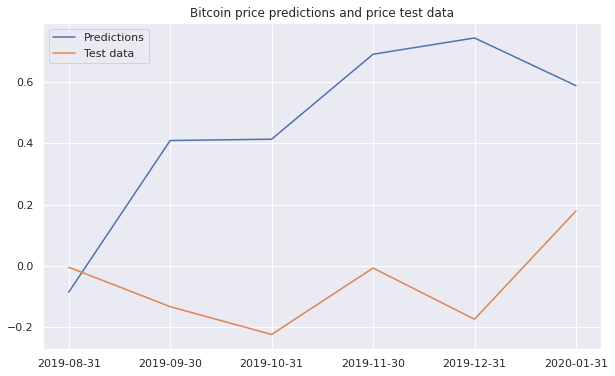

In [180]:
##training and testing with different variable combinations
#Testing with the change in the supply curve of bitcoins (SplyCur).
X_train_columns = ['AdrActCnt', 'TxCnt', 'TxTfrValAdjNtv', 'TxTfrValMeanNtv', 'TxTfrValNtv', 'SplyCur']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'ctt', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.9797885438316536
Explained variance: 0.9797885438316536
MAE: 0.0169060633011704
MSE: 0.0005517619147729768
RMSE: 0.023489612912369943
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


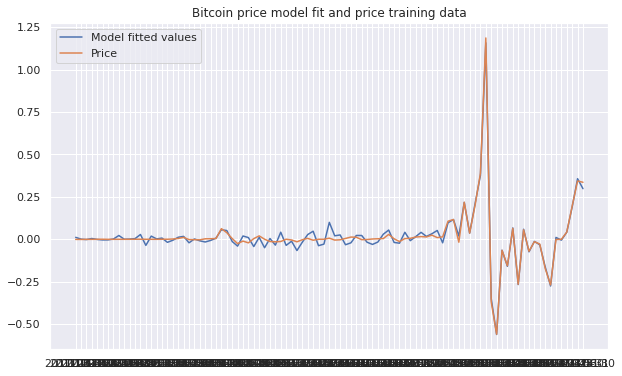

--------------------------------------------
model max lags: 12
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:28:40
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -18.7407
Nobs:                     95.0000    HQIC:                  -28.4970
Log likelihood:           1333.24    FPE:                4.80460e-12
AIC:                     -35.1124    Det(Omega_mle):     5.07251e-14
--------------------------------------------------------------------
Results for equation AdrActCnt
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.073590         0.154632           -0.476           0.634
trend                       0.002355         0.005355  

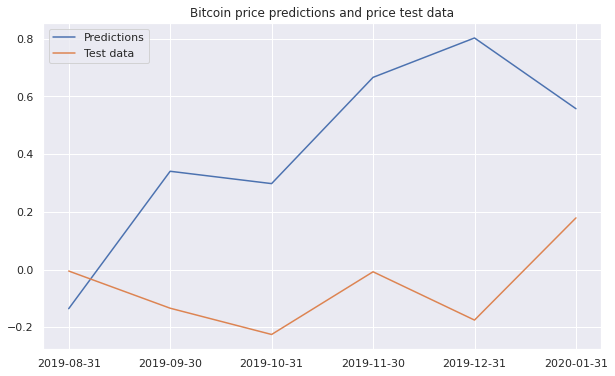

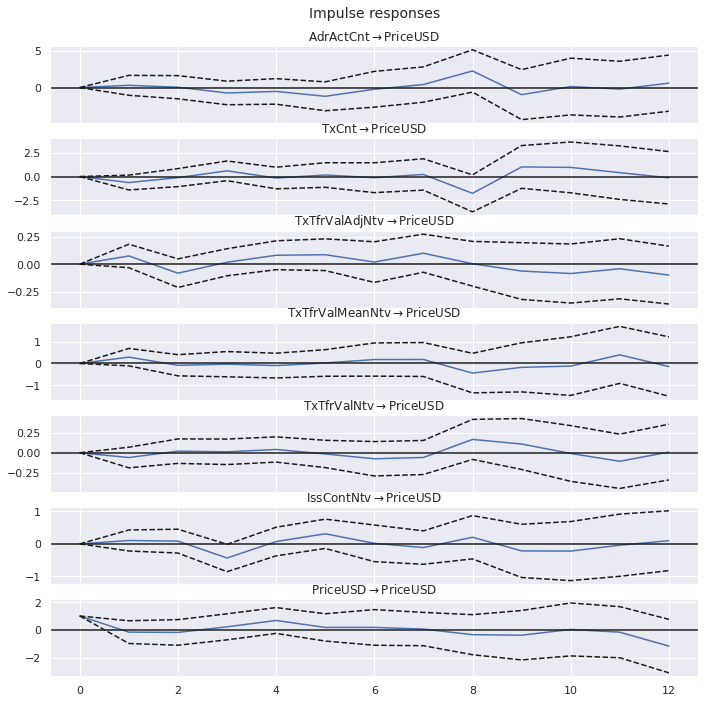

In [181]:
#impulse response plots on the best model 
X_train_columns = ['AdrActCnt', 'TxCnt', 'TxTfrValAdjNtv', 'TxTfrValMeanNtv', 'TxTfrValNtv', 'IssContNtv']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

best_model_results = train_test_model(train_df, y_test, 'aic', 'ctt', 'PriceUSD')


irf = best_model_results.irf(best_model_results.k_ar)
irf.plot(response='PriceUSD', orth=False)
plt.show()

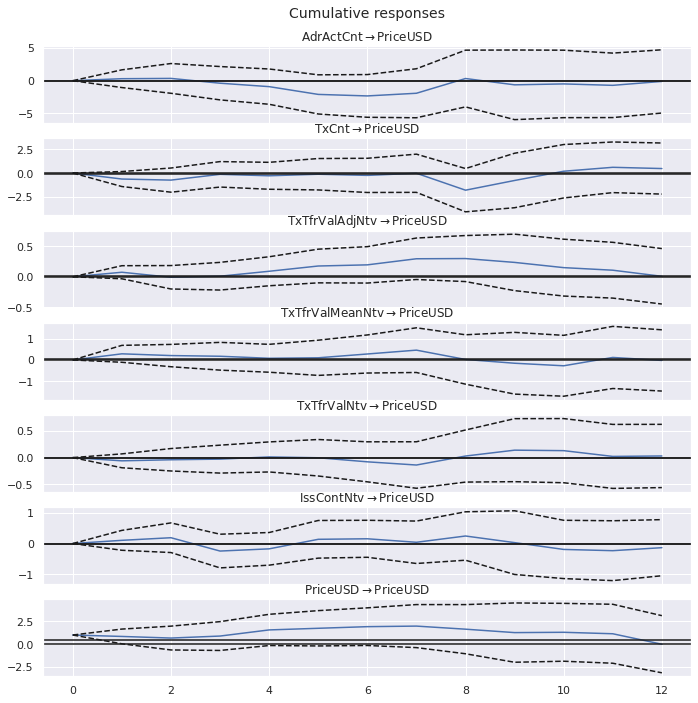

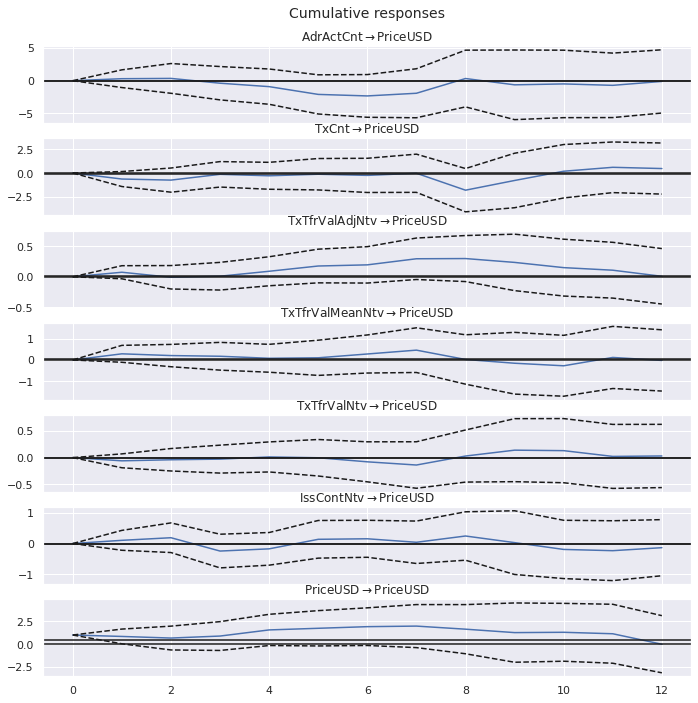

In [182]:
#cummulative impulse response plots
irf.plot_cum_effects(response='PriceUSD', orth=False)

In [183]:
#Conclusions
'''
1. We found that the best VAR model by tunning the hyperparameters of Information Criterion (ic) and Trend.
   The best ic was aic and the best trend was ctt.
2. After testing various combinations of variables in the best VAR model, we found that the best combinations for
   predicting the bitcoin prices under this model was 'AdrActCnt', 'TxCnt', 'TxTfrValAdjNtv', 'TxTfrValMeanNtv', 
   'TxTfrValNtv', 'IssContNtv', which is a combination of network usage (addresses and transactions) and supply 
   growth (IssContNtv).
3. It is worth noting that the best models scored very well on the training set, but these scores decreased
   somehow significantly on the training set.
   
'''

"\n1. We found that the best VAR model by tunning the hyperparameters of Information Criterion (ic) and Trend.\n   The best ic was aic and the best trend was ctt.\n2. After testing various combinations of variables in the best VAR model, we found that the best combinations for\n   predicting the bitcoin prices under this model was 'AdrActCnt', 'TxCnt', 'TxTfrValAdjNtv', 'TxTfrValMeanNtv', \n   'TxTfrValNtv', 'IssContNtv', which is a combination of network usage (addresses and transactions) and supply \n   growth (IssContNtv).\n3. It is worth noting that the best models scored very well on the training set, but these scores decreased\n   somehow significantly on the training set.\n   \n"

<h1>Modeling with weekly data</h1>


In [184]:
#load scaled weekly changes
weekly_scaled_changes = pd.read_csv('../data/processed/scaled_weekly_diff.csv')
weekly_scaled_changes.index = weekly_scaled_changes['time']
weekly_scaled_changes = weekly_scaled_changes.drop('time', axis=1)
weekly_scaled_changes.tail()


AdrActCnt    BlkCnt  BlkSizeByte  BlkSizeMeanByte  CapMVRVCur  \
time                                                                        
2021-01-24  -0.204097 -0.262402    -0.133486        -0.029746   -0.047290   
2021-01-31   0.118130  0.145779     0.112035         0.052992   -0.019465   
2021-02-07   0.131116  0.335291     0.114143        -0.016993    0.040676   
2021-02-14  -0.006064 -0.306135    -0.136805        -0.021332    0.086542   
2021-02-21  -0.230481 -4.468118    -1.772068        -0.004813    0.009477   

            CapMrktCurUSD  CapRealUSD  DiffMean  FeeMeanNtv  FeeMeanUSD  ...  \
time                                                                     ...   
2021-01-24      -0.421292    0.119012  0.008834   -0.113583   -0.944314  ...   
2021-01-31      -0.142314    0.080403  0.029146    0.050154    0.262886  ...   
2021-02-07       0.713366    0.149839  0.029901    0.075141    0.826541  ...   
2021-02-14       1.656486    0.340257  0.077453    0.133213    2.121120  ...   
2021-02-21       0.471635    0.212073  0.000000   -0.102840   -0.574356  ...   

            TxTfrValMeanUSD  TxTfrValMedNtv  TxTfrValMedUSD  TxTfrValNtv  \
time                                                                       
2021-01-24        -0.599853       -0.000062       -0.363686    -0.048455   
2021-01-31        -0.011640        0.000025       -0.012121     0.030935   
2021-02-07         0.065962       -0.000033        0.241200    -0.021436   
2021-02-14         1.218637       -0.000057        0.590058     0.025520   
2021-02-21        -0.005625       -0.000055        0.026124    -0.226190   

            TxTfrValUSD  VtyDayRet180d  VtyDayRet30d  VtyDayRet60d  \
time                                                                 
2021-01-24    -0.836591       0.062793      0.177713      0.127143   
2021-01-31     0.214690       0.038535      0.164573      0.042596   
2021-02-07     0.226377       0.021409     -0.055985      0.019283   
2021-02-14     1.498233       0.094001      0.079520      0.149846   
2021-02-21    -3.390227       0.003854     -0.115367     -0.029469   

            block_height  halving_period  
time                                      
2021-01-24      0.005773             0.0  
2021-01-31      0.005889             0.0  
2021-02-07      0.006154             0.0  
2021-02-14      0.005912             0.0  
2021-02-21      0.002373             0.0  

[5 rows x 44 columns]

In [185]:
#Gap train-test split

X = weekly_scaled_changes.drop('PriceUSD', axis=1)
y = weekly_scaled_changes['PriceUSD']

X_trainW, X_holdW, y_trainW, y_holdW = gap_train_test_split(X, y, test_size=52, gap_size=4) 

X_train2W, X_testW, y_train2W, y_testW = gap_train_test_split(X_trainW, y_trainW, test_size=52, gap_size=4)

/home/julio/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


--------------------------------------------
Training set scores
r2: 0.29646024821389405
Explained variance: 0.2964602482138937
MAE: 0.026045555466674985
MSE: 0.003412357871529017
RMSE: 0.05841539070766382
--------------------------------------------


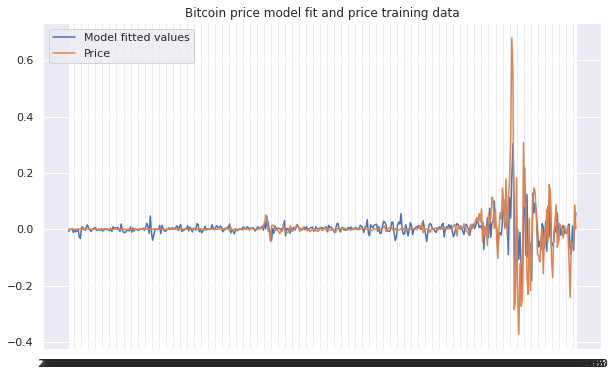

--------------------------------------------
model max lags: 5
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:29:03
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -16.6108
Nobs:                     436.000    HQIC:                  -17.7318
Log likelihood:           510.904    FPE:                9.60617e-09
AIC:                     -18.4626    Det(Omega_mle):     6.20058e-09
--------------------------------------------------------------------
Results for equation AdrActCnt
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.010595         0.013179           -0.804           0.421
trend                      0.000212         0.000137       

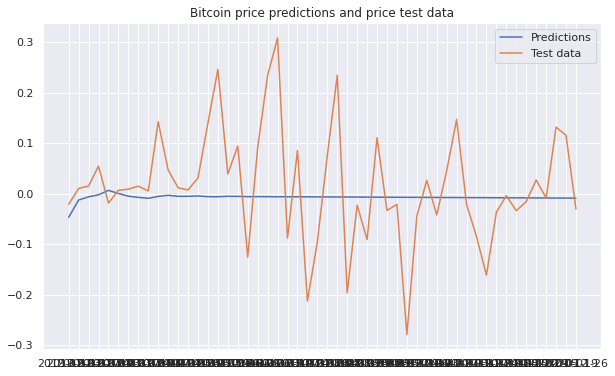

In [186]:
##training and testing with different variable combinations
#Testing with the change in the supply curve of bitcoins (SplyCur).
X_train_columns = ['AdrActCnt', 'TxCnt', 'TxTfrValAdjNtv', 'TxTfrValMeanNtv', 'TxTfrValNtv']
X_train_to_model = X_train2W[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train2W], axis=1)

print(train_test_model(train_df, y_testW, 'aic', 'ctt', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.575765993170104
Explained variance: 0.575765993170104
MAE: 0.025468529145086787
MSE: 0.0021158590891294437
RMSE: 0.04599846833460266
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


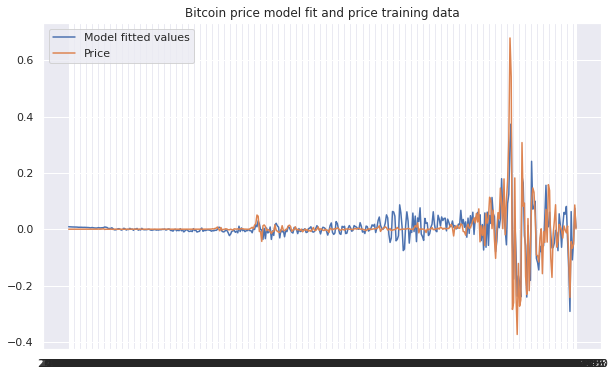

--------------------------------------------
model max lags: 17
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:29:19
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -18.1751
Nobs:                     424.000    HQIC:                  -19.1111
Log likelihood:           2538.26    FPE:                2.73200e-09
AIC:                     -19.7224    Det(Omega_mle):     1.90676e-09
--------------------------------------------------------------------
Results for equation AdrActCnt
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.005304         0.014253            0.372           0.710
trend                -0.000078         0.000168           -0.462         

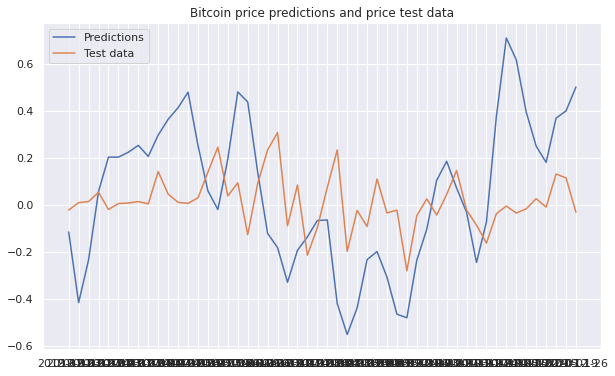

In [187]:
#training and testing with different variable combinations
#Testing with the change in the supply curve of bitcoins (SplyCur).
X_train_columns = ['AdrActCnt', 'HashRate']
X_train_to_model = X_train2W[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train2W], axis=1)

print(train_test_model(train_df, y_testW, 'aic', 'ctt', 'PriceUSD'))


--------------------------------------------
Training set scores
r2: 0.5185442675839611
Explained variance: 0.518544267583961
MAE: 0.026503954671694457
MSE: 0.002401251363741832
RMSE: 0.04900256486901305
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


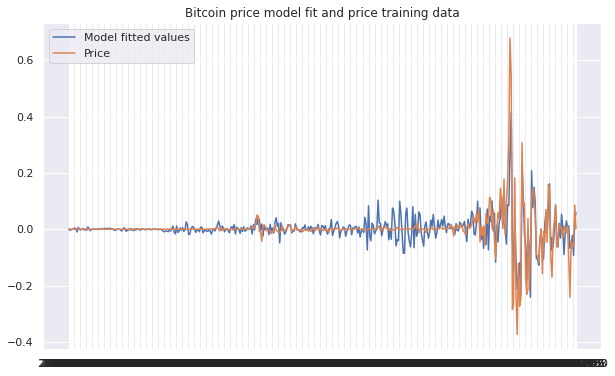

--------------------------------------------
model max lags: 17
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:29:36
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -15.0171
Nobs:                     424.000    HQIC:                  -15.9531
Log likelihood:           1868.76    FPE:                6.42672e-08
AIC:                     -16.5644    Det(Omega_mle):     4.48542e-08
--------------------------------------------------------------------
Results for equation AdrActCnt
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.014741         0.013587           -1.085           0.278
trend                 0.000254         0.000141            1.799         

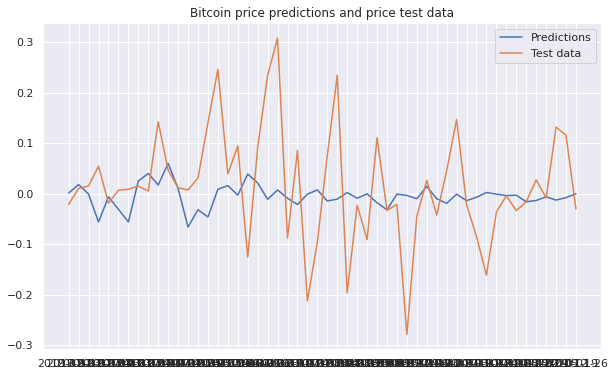

In [188]:
#training and testing with different variable combinations
#Testing with the change in the supply curve of bitcoins (SplyCur).
X_train_columns = ['AdrActCnt', 'TxCnt']
X_train_to_model = X_train2W[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train2W], axis=1)

print(train_test_model(train_df, y_testW, 'aic', 'ctt', 'PriceUSD'))


--------------------------------------------
Training set scores
r2: 0.2983045011020319
Explained variance: 0.29830450110203177
MAE: 0.026130843461662882
MSE: 0.0034034127467596625
RMSE: 0.058338775670729176
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


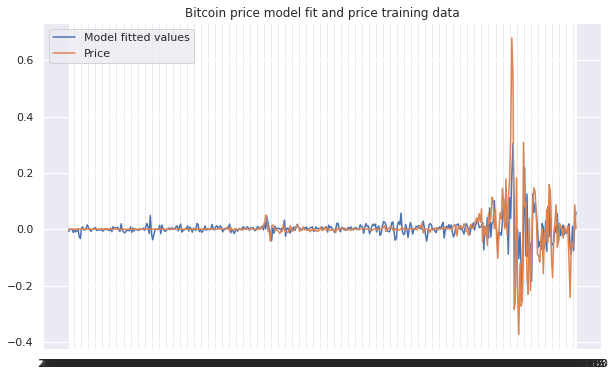

--------------------------------------------
model max lags: 5
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:29:53
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -19.8358
Nobs:                     436.000    HQIC:                  -21.3418
Log likelihood:           801.931    FPE:                2.02468e-10
AIC:                     -22.3235    Det(Omega_mle):     1.12801e-10
--------------------------------------------------------------------
Results for equation AdrActCnt
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.010776         0.013119           -0.821           0.411
trend                      0.000214         0.000136       

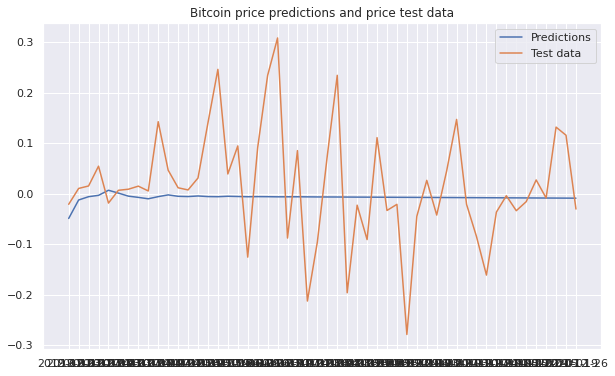

In [189]:
#training and testing with different variable combinations
X_train_columns = ['AdrActCnt', 'TxCnt', 'TxTfrCnt', 'TxTfrValAdjNtv', 'TxTfrValMeanNtv', 'TxTfrValNtv']
X_train_to_model = X_train2W[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train2W], axis=1)

print(train_test_model(train_df, y_testW, 'aic', 'ctt', 'PriceUSD'))




--------------------------------------------
Training set scores
r2: 0.3910967248692129
Explained variance: 0.3910967248692129
MAE: 0.028160544408877206
MSE: 0.0029875919383390106
RMSE: 0.054658868798567455
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


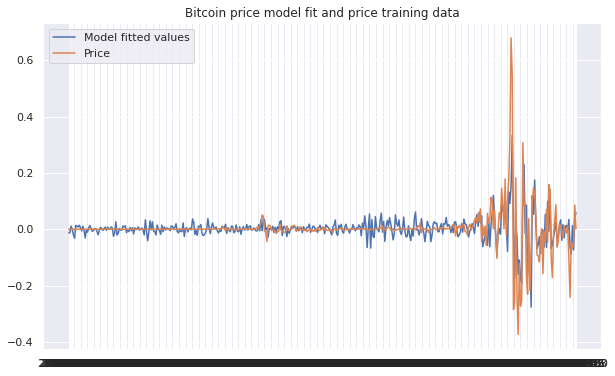

--------------------------------------------
model max lags: 10
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:30:10
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -17.0646
Nobs:                     431.000    HQIC:                  -19.9820
Log likelihood:           946.364    FPE:                3.20123e-10
AIC:                     -21.8854    Det(Omega_mle):     1.07064e-10
--------------------------------------------------------------------
Results for equation AdrActCnt
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.006061         0.013489           -0.449           0.653
trend                       0.000155         0.000138  

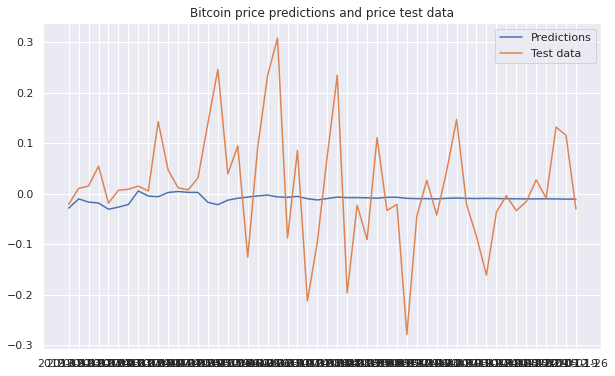

In [190]:
#training and testing with different variable combinations
X_train_columns = ['AdrActCnt', 'TxCnt', 'TxTfrValAdjNtv', 'TxTfrValMeanNtv', 'TxTfrValNtv', 'IssContNtv']
X_train_to_model = X_train2W[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train2W], axis=1)

print(train_test_model(train_df, y_testW, 'aic', 'ctt', 'PriceUSD'))



--------------------------------------------
Training set scores
r2: 0.45405054643738807
Explained variance: 0.45405054643738796
MAE: 0.02599596256431626
MSE: 0.0027229125787383754
RMSE: 0.05218153484460164
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


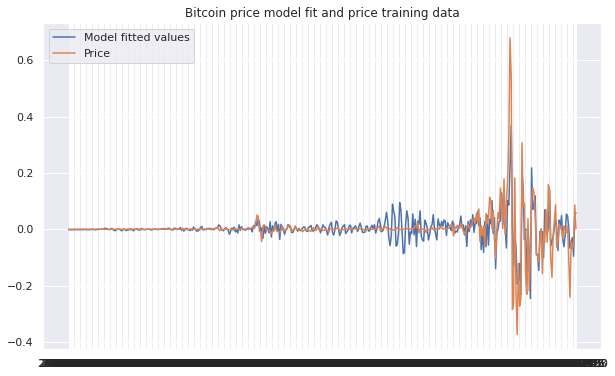

--------------------------------------------
model max lags: 17
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:30:27
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -10.2584
Nobs:                     424.000    HQIC:                  -10.6859
Log likelihood:           1195.36    FPE:                1.73090e-05
AIC:                     -10.9652    Det(Omega_mle):     1.46420e-05
--------------------------------------------------------------------
Results for equation AdrActCnt
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.011550         0.013577           -0.851           0.395
trend                 0.000208         0.000140            1.485         

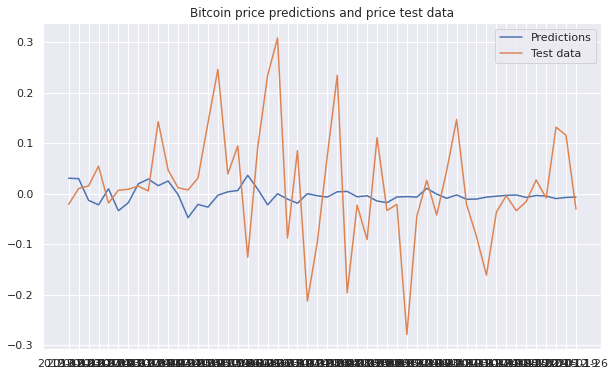

In [191]:
#training and testing with different variable combinations
X_train_columns = ['AdrActCnt']
X_train_to_model = X_train2W[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train2W], axis=1)

print(train_test_model(train_df, y_testW, 'aic', 'ctt', 'PriceUSD'))


--------------------------------------------
Training set scores
r2: 0.39114265965088424
Explained variance: 0.39114265965088424
MAE: 0.02815846802239601
MSE: 0.0029873665587278053
RMSE: 0.05465680706671224
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


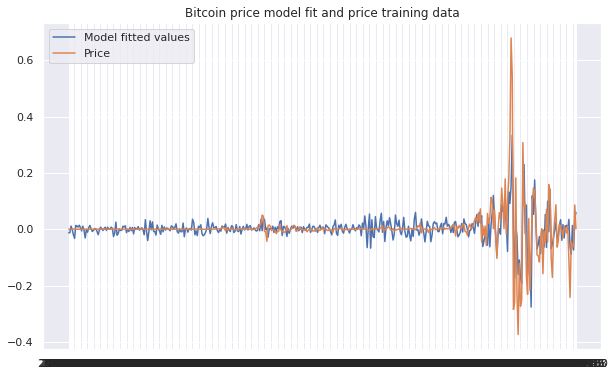

--------------------------------------------
model max lags: 10
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:30:43
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -27.9154
Nobs:                     431.000    HQIC:                  -30.8329
Log likelihood:           3284.73    FPE:                6.20635e-15
AIC:                     -32.7363    Det(Omega_mle):     2.07569e-15
--------------------------------------------------------------------
Results for equation AdrActCnt
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.008347         0.061271            0.136           0.892
trend                       0.000103         0.000259  

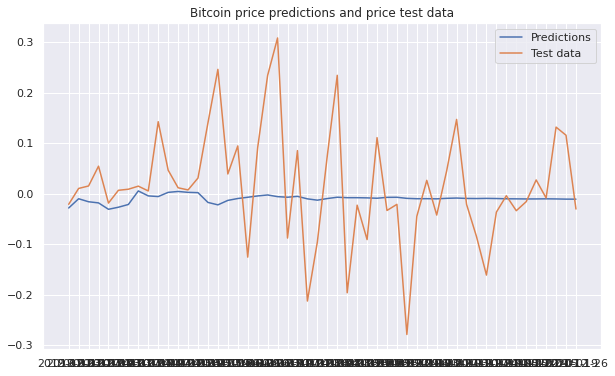

In [192]:

X_train_columns = ['AdrActCnt', 'TxCnt', 'TxTfrValAdjNtv', 'TxTfrValMeanNtv', 'TxTfrValNtv', 'SplyCur']
X_train_to_model = X_train2W[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train2W], axis=1)

print(train_test_model(train_df, y_testW, 'aic', 'ctt', 'PriceUSD'))

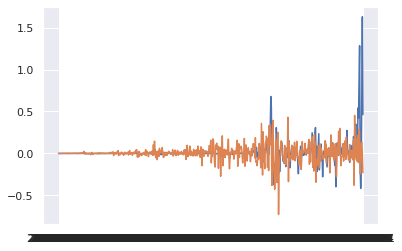

In [193]:
plt.plot(weekly_scaled_changes['PriceUSD'])
plt.plot(weekly_scaled_changes['AdrActCnt'])
plt.show()

/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


--------------------------------------------
Training set scores
r2: 0.28904329719736443
Explained variance: 0.28904329719736455
MAE: 0.023483617129140863
MSE: 0.003504573840624106
RMSE: 0.05919944121885025
--------------------------------------------


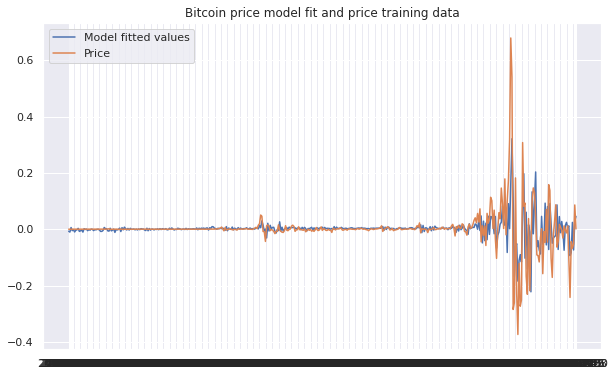

--------------------------------------------
model max lags: 12
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:31:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -8.43858
Nobs:                     429.000    HQIC:                  -8.74792
Log likelihood:           756.286    FPE:                0.000129804
AIC:                     -8.94981    Det(Omega_mle):     0.000114888
--------------------------------------------------------------------
Results for equation IssTotNtv
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.018827         0.028714           -0.656           0.512
trend                 0.000004         0.000290            0.014         

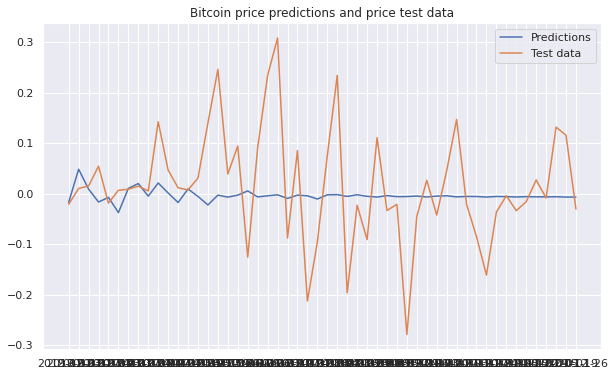

In [194]:
#training and testing with different variable combinations
X_train_columns = ['IssTotNtv']
X_train_to_model = X_train2W[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train2W], axis=1)

print(train_test_model(train_df, y_testW, 'aic', 'ctt', 'PriceUSD'))

<h1> Modeling with 4-year % change mothly and weekly data </h1>

In [195]:
#load monthly and weekly 4-year % change.

#monthly data.
monthly_pct4 = pd.read_csv('../data/processed/monthly_pct4.csv')
monthly_pct4.index = monthly_pct4['time']
monthly_pct4 = monthly_pct4.drop('time', axis=1)
monthly_pct4.tail()

AdrActCnt     BlkCnt  BlkSizeByte  BlkSizeMeanByte  CapMVRVCur  \
time                                                                         
2020-10-31  68.641688  -7.548415    39.649052        50.852093    9.774206   
2020-11-30  66.966045  -1.041436    44.364401        45.736292   27.983958   
2020-12-31  67.954148  -3.793691    41.730005        46.825644   35.404241   
2021-01-31  77.535959  -5.639251    42.720907        50.179362   53.916711   
2021-02-28  71.020962 -41.222092   -18.882869        37.863497   50.353932   

            CapMrktCurUSD   CapRealUSD     DiffMean  FeeMeanNtv   FeeMeanUSD  \
time                                                                           
2020-10-31    2051.269071  1858.118339  7659.016877   22.621501  2256.627551   
2020-11-30    2565.664437  1978.488623  6477.288114   16.345662  2446.754058   
2020-12-31    2984.410320  2168.945057  6184.187638  -11.676187  2298.848102   
2021-01-31    4297.171984  2768.487248  5692.672363  -19.736397  2957.143071   
2021-02-28    4595.544145  3014.429366  4899.426816  -19.760065  3168.453921   

            ...  TxTfrValMedNtv  TxTfrValMedUSD  TxTfrValNtv  TxTfrValUSD  \
time        ...                                                             
2020-10-31  ...      -64.828054      548.256397   -70.804729   442.376071   
2020-11-30  ...      -69.653038      593.451570   -73.054235   522.016986   
2020-12-31  ...      -77.632895      493.800190   -56.711429  1064.623701   
2021-01-31  ...      -79.224832      696.973286   -54.768146  1642.563009   
2021-02-28  ...      -81.641762      642.222074   -70.503554  1101.683607   

            VtyDayRet180d  VtyDayRet30d  VtyDayRet60d  block_height  \
time                                                                  
2020-10-31      -1.894277     76.015394    109.551690     49.928806   
2020-11-30      -9.843067     32.850347     43.283896     49.407606   
2020-12-31      12.057206    145.882647     77.304740     48.847966   
2021-01-31      24.584611      1.691735     23.252134     48.254459   
2021-02-28      41.393077     86.911180     23.800562     47.418081   

            halving_period  AdrActCnt2  
time                                    
2020-10-31            50.0  184.400188  
2020-11-30            50.0  178.776601  
2020-12-31            50.0  182.085959  
2021-01-31            50.0  215.190166  
2021-02-28            50.0  192.481695  

[5 rows x 45 columns]

In [196]:
#weekly data.
weekly_pct4 = pd.read_csv('../data/processed/weekly_pct4.csv')
weekly_pct4.index = weekly_pct4['time']
weekly_pct4 = weekly_pct4.drop('time', axis=1)
weekly_pct4.tail()

AdrActCnt     BlkCnt  BlkSizeByte  BlkSizeMeanByte  CapMVRVCur  \
time                                                                         
2021-01-24  60.162699  -7.407407    31.032983        41.197717   44.834437   
2021-01-31  63.348169  -6.422018    29.705835        38.559093   29.188478   
2021-02-07  77.797614   4.818092    45.449641        38.815344   39.976066   
2021-02-14  76.028698  -3.213611    34.678020        38.769380   64.698104   
2021-02-21  58.749911 -62.014787   -48.191088        36.199990   53.977463   

            CapMrktCurUSD   CapRealUSD     DiffMean  FeeMeanNtv   FeeMeanUSD  \
time                                                                           
2021-01-24    4180.309092  2855.767286  5156.900146  -34.797503  2311.590334   
2021-01-31    3727.491268  2862.789923  5140.370472  -31.595924  2188.146221   
2021-02-07    4109.560442  2905.913619  4872.794135  -22.576616  2710.047697   
2021-02-14    5137.851497  3080.710057  4926.253350   -3.061257  4300.178757   
2021-02-21    4885.739103  3137.772706  4762.834229  -32.618329  2821.262897   

            ...  TxTfrValMedUSD  TxTfrValNtv  TxTfrValUSD  VtyDayRet180d  \
time        ...                                                            
2021-01-24  ...      648.289985   -48.802064  1821.794587      22.329806   
2021-01-31  ...      565.833370   -54.437491  1408.875397      37.764141   
2021-02-07  ...      597.611712   -51.417386  1666.313160      37.306330   
2021-02-14  ...      693.396215   -45.795384  2352.653570      44.562444   
2021-02-21  ...      652.452091   -79.718945   780.617015      43.085354   

            VtyDayRet30d  VtyDayRet60d  block_height  halving_period  \
time                                                                   
2021-01-24      0.643608     17.800405     48.123197            50.0   
2021-01-31     19.558795     19.539755     47.991588            50.0   
2021-02-07     67.221395     18.030164     47.894612            50.0   
2021-02-14    134.916476     26.389141     47.775464            50.0   
2021-02-21    139.018676     26.289837     47.514327            50.0   

            AdrActCnt2         S2F  
time                                
2021-01-24  156.520901  149.154138  
2021-01-31  166.826244  146.406865  
2021-02-07  216.119917  119.889167  
2021-02-14  209.861027  138.023370  
2021-02-21  152.015341  506.060623  

[5 rows x 46 columns]

In [197]:
#Gap train-test split for monthly data.

X = monthly_pct4.drop('PriceUSD', axis=1)
y = monthly_pct4['PriceUSD']

X_train, X_hold, y_train, y_hold = gap_train_test_split(X, y, test_size=6, gap_size=1) 

X_train, X_test, y_train, y_test = gap_train_test_split(X_train, y_train, test_size=6, gap_size=1)

/home/julio/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


--------------------------------------------
Training set scores
r2: 0.9712336878016034
Explained variance: 0.9712336878016034
MAE: 400.684609329326
MSE: 256180.40829399752
RMSE: 506.14267582767366
--------------------------------------------


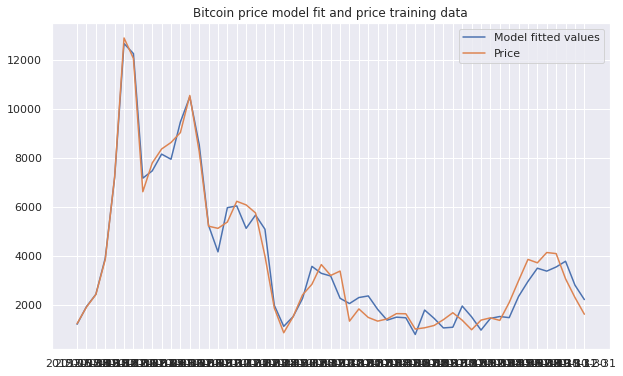

--------------------------------------------
model max lags: 11
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:31:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    24.8608
Nobs:                     55.0000    HQIC:                   23.8312
Log likelihood:          -747.587    FPE:                1.30384e+10
AIC:                      23.1819    Det(Omega_mle):     6.48278e+09
--------------------------------------------------------------------
Results for equation AdrActCnt
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                17.505760        35.415345            0.494           0.621
L1.AdrActCnt          0.604629         0.183484            3.295         

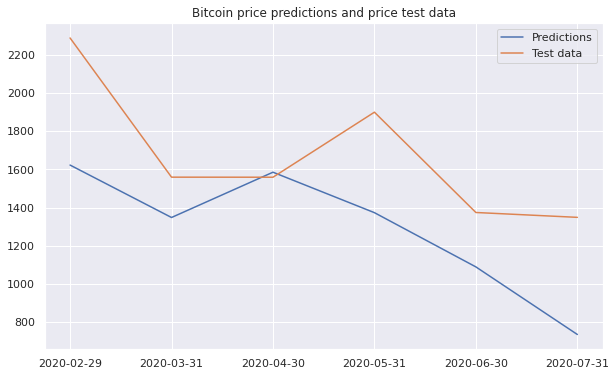

In [198]:
#training and testing with different variable combinations
X_train_columns = ['AdrActCnt']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.9735199742572034
Explained variance: 0.9735199742572034
MAE: 349.25385696671793
MSE: 235819.7241147688
RMSE: 485.61273059380227
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


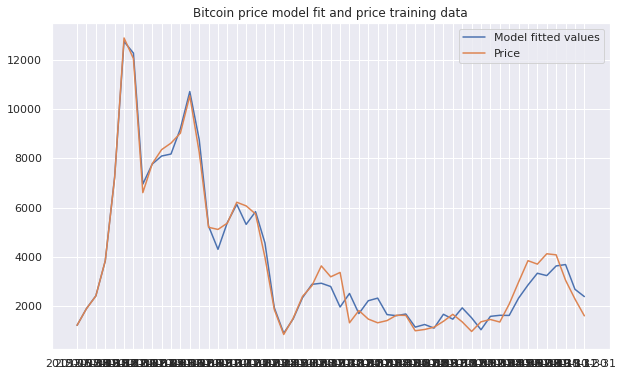

--------------------------------------------
model max lags: 11
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:31:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    31.7575
Nobs:                     55.0000    HQIC:                   30.7279
Log likelihood:          -937.246    FPE:                1.28951e+13
AIC:                      30.0787    Det(Omega_mle):     6.41154e+12
--------------------------------------------------------------------
Results for equation AdrActCnt2
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const               1132.160551      1836.706451            0.616           0.538
L1.AdrActCnt2          0.578398         0.169120            3.420    

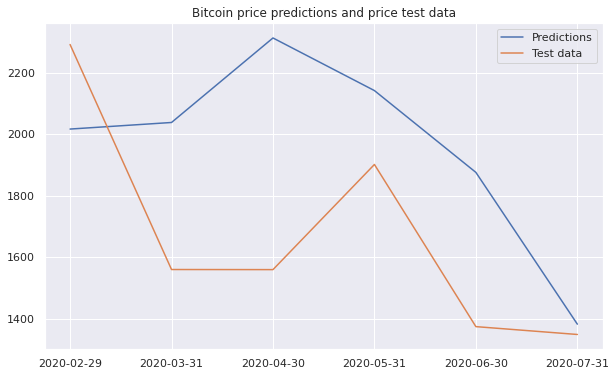

In [199]:
#training and testing with different variable combinations
X_train_columns = ['AdrActCnt2']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.885922310805821
Explained variance: 0.8859251392203907
MAE: 698.0998117762346
MSE: 997800.3091943488
RMSE: 998.899549101084
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


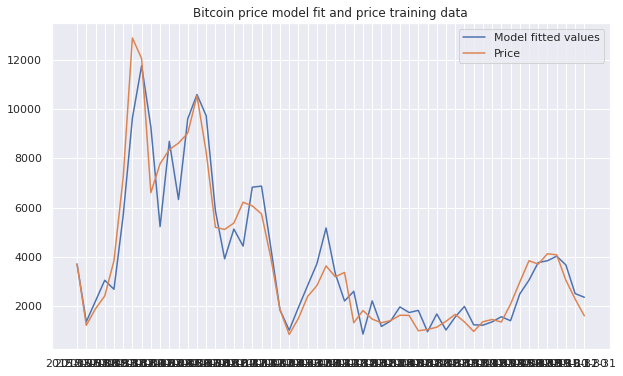

--------------------------------------------
model max lags: 10
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:31:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    19.7911
Nobs:                     56.0000    HQIC:                   18.9053
Log likelihood:          -632.565    FPE:                9.89669e+07
AIC:                      18.3444    Det(Omega_mle):     5.37327e+07
--------------------------------------------------------------------
Results for equation IssTotNtv
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
L1.IssTotNtv          0.895078         0.164171            5.452           0.000
L1.PriceUSD           0.000075         0.000713            0.106         

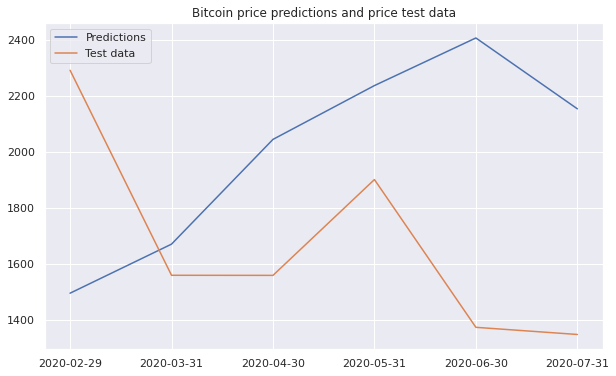

In [200]:
X_train_columns = ['IssTotNtv']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'n', 'PriceUSD'))

In [201]:
#Gap train-test split for weekly data.

X = weekly_pct4.drop('PriceUSD', axis=1)
y = weekly_pct4['PriceUSD']

X_train, X_hold, y_train, y_hold = gap_train_test_split(X, y, test_size=8, gap_size=2) 

X_train, X_test, y_train, y_test = gap_train_test_split(X_train, y_train, test_size=8, gap_size=2)

X_train.tail()
#print(len(X_hold))
print(y_hold)

time
2021-01-03    2900.384953
2021-01-10    4343.761133
2021-01-17    3960.385326
2021-01-24    3609.921713
2021-01-31    3219.145811
2021-02-07    3552.121038
2021-02-14    4446.397104
2021-02-21    4229.983044
Name: PriceUSD, dtype: float64


/home/julio/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


--------------------------------------------
Training set scores
r2: 0.9992817049111591
Explained variance: 0.9992817049111591
MAE: 398.12182316605254
MSE: 448103.2413878922
RMSE: 669.4051399473209
--------------------------------------------


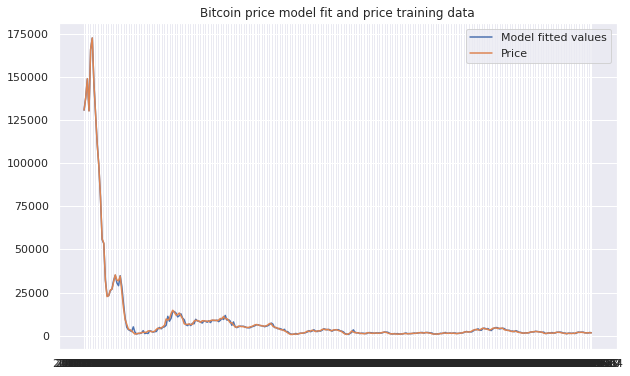

--------------------------------------------
model max lags: 16
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:31:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    34.8109
Nobs:                     310.000    HQIC:                   34.3334
Log likelihood:          -6086.12    FPE:                5.93452e+14
AIC:                      34.0154    Det(Omega_mle):     4.84753e+14
--------------------------------------------------------------------
Results for equation AdrActCnt2
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const             -12169.564302      3411.090647           -3.568           0.000
L1.AdrActCnt2          0.290011         0.043707            6.635    

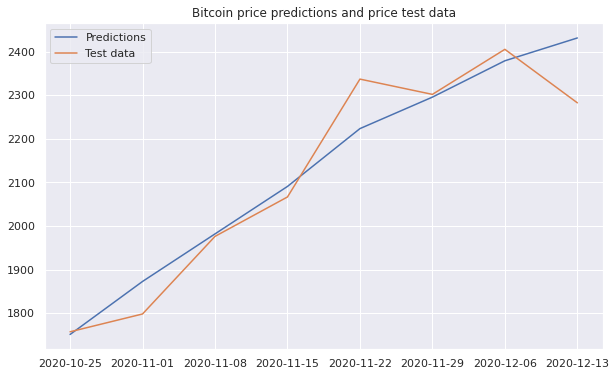

In [202]:
X_train_columns = ['AdrActCnt2']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.9992510825123208
Explained variance: 0.9992510825123208
MAE: 426.1345653877953
MSE: 467206.80535718857
RMSE: 683.525277774852
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


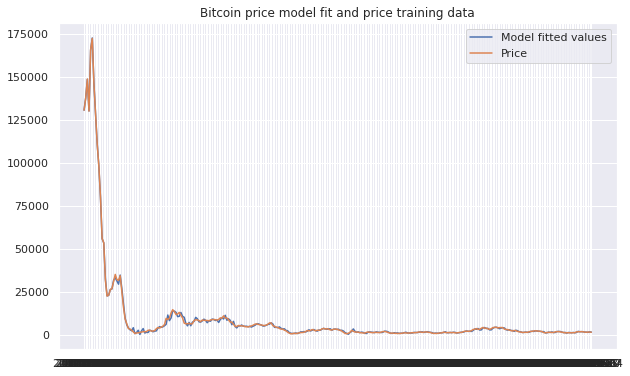

--------------------------------------------
model max lags: 16
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:31:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    25.0867
Nobs:                     310.000    HQIC:                   24.6092
Log likelihood:          -4578.88    FPE:                3.55012e+10
AIC:                      24.2912    Det(Omega_mle):     2.89987e+10
--------------------------------------------------------------------
Results for equation AdrActCnt
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -8.408970        19.886610           -0.423           0.672
L1.AdrActCnt          0.396173         0.047312            8.374         

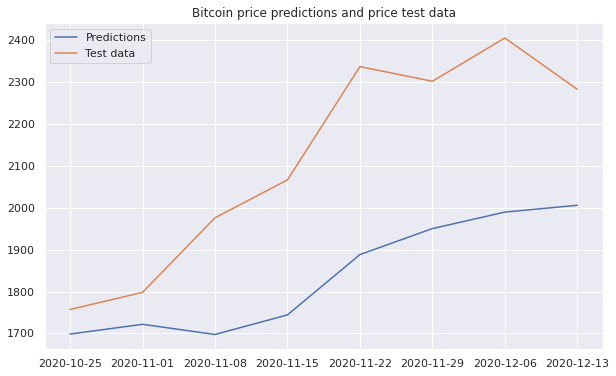

In [203]:
X_train_columns = ['AdrActCnt']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.9997116468703594
Explained variance: 0.9997116468703594
MAE: 297.9469799576033
MSE: 179887.03259099202
RMSE: 424.13091444858395
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


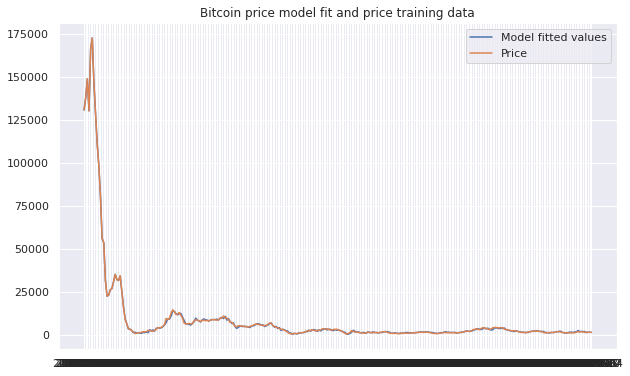

--------------------------------------------
model max lags: 16
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:32:05
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    66.5714
Nobs:                     310.000    HQIC:                   63.6412
Log likelihood:          -11356.3    FPE:                6.58326e+26
AIC:                      61.6897    Det(Omega_mle):     2.06237e+26
--------------------------------------------------------------------
Results for equation AdrActCnt
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const              -172.257340       128.961678           -1.336           0.182
L1.AdrActCnt          0.583027         0.111380            5.235         

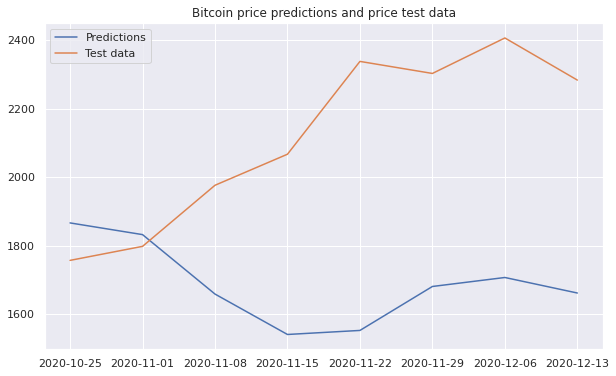

In [204]:
X_train_columns = ['AdrActCnt', 'TxCnt', 'IssTotNtv', 'HashRate']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.9995283857660395
Explained variance: 0.9995283857660395
MAE: 337.4458228907258
MSE: 294213.1586384291
RMSE: 542.4141947243168
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


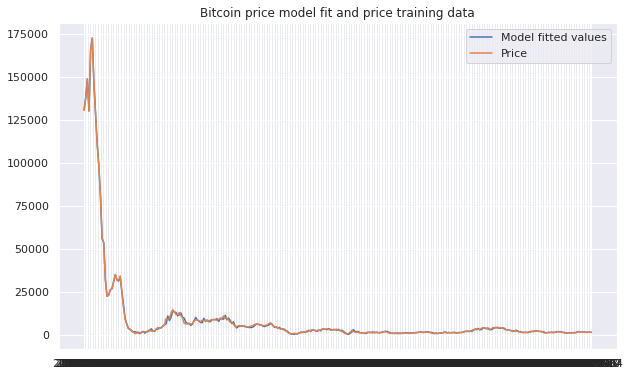

--------------------------------------------
model max lags: 16
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:32:16
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    35.1161
Nobs:                     310.000    HQIC:                   34.0526
Log likelihood:          -6340.97    FPE:                3.05282e+14
AIC:                      33.3442    Det(Omega_mle):     1.96564e+14
--------------------------------------------------------------------
Results for equation AdrActCnt
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                23.689551        16.068283            1.474           0.140
L1.AdrActCnt          0.814277         0.090815            8.966         

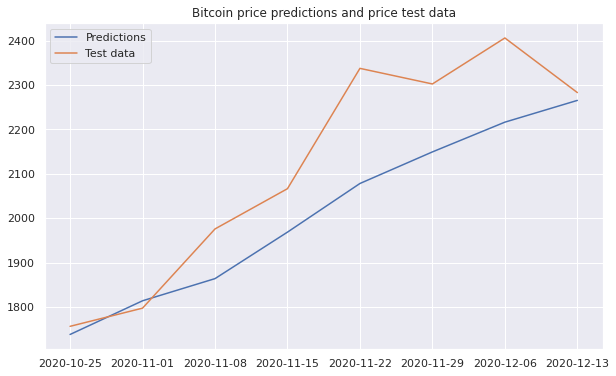

In [205]:
X_train_columns = ['AdrActCnt', 'TxCnt']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD'))



--------------------------------------------
Training set scores
r2: 0.9996837560255226
Explained variance: 0.9996837560255226
MAE: 307.2850758510716
MSE: 197286.53618023987
RMSE: 444.1694903752844
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


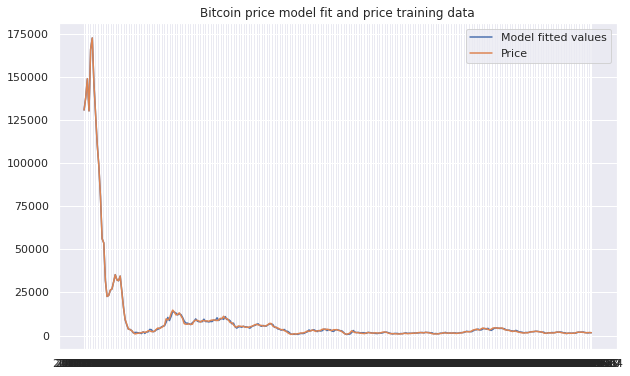

--------------------------------------------
model max lags: 16
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:32:28
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    53.6491
Nobs:                     310.000    HQIC:                   51.7680
Log likelihood:          -9329.34    FPE:                8.90076e+21
AIC:                      50.5152    Det(Omega_mle):     4.15670e+21
--------------------------------------------------------------------
Results for equation AdrActCnt
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                -21.580115        20.012491           -1.078           0.281
L1.AdrActCnt           0.605434         0.096991            6.242     

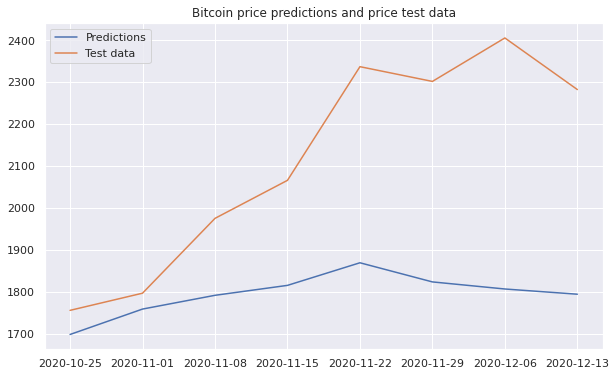

In [206]:

X_train_columns = ['AdrActCnt', 'TxCnt', 'AdrActCnt2']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.9997495487727975
Explained variance: 0.9997495487727975
MAE: 281.1209545845313
MSE: 156242.20249105222
RMSE: 395.2748442426513
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


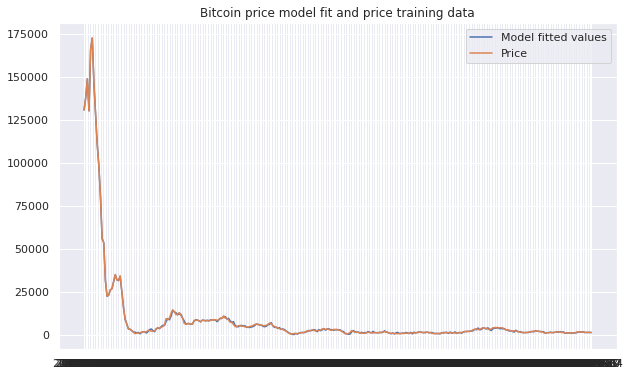

--------------------------------------------
model max lags: 16
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:32:39
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    62.8697
Nobs:                     310.000    HQIC:                   58.6589
Log likelihood:          -10714.7    FPE:                2.06027e+24
AIC:                      55.8546    Det(Omega_mle):     4.02280e+23
--------------------------------------------------------------------
Results for equation AdrActCnt
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                    -300.286344       102.908828           -2.918           0.004
L1.AdrActCnt                0.964945         0.101789  

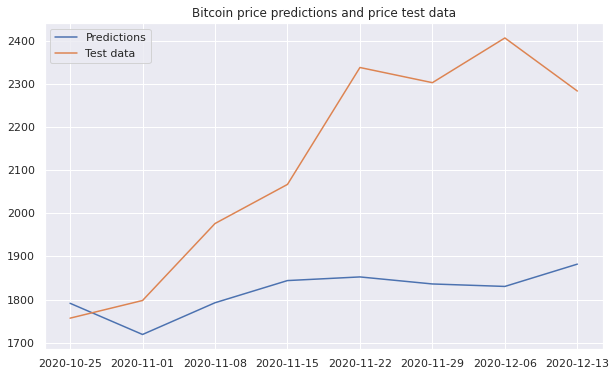

In [207]:
X_train_columns = ['AdrActCnt', 'TxCnt', 'TxTfrValAdjNtv', 'TxTfrValMeanNtv', 'TxTfrValNtv']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.9981364080429874
Explained variance: 0.9981364080429874
MAE: 632.8669901587972
MSE: 1162588.4814404233
RMSE: 1078.2339641471249
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


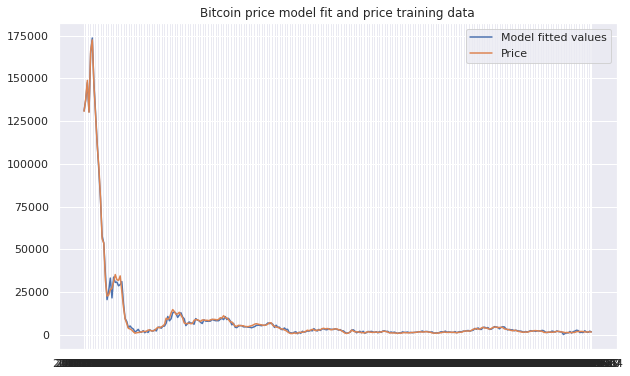

--------------------------------------------
model max lags: 16
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:32:50
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    18.2321
Nobs:                     310.000    HQIC:                   17.7546
Log likelihood:          -3516.40    FPE:                3.74364e+07
AIC:                      17.4365    Det(Omega_mle):     3.05795e+07
--------------------------------------------------------------------
Results for equation IssContNtv
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -8.980639         2.879822           -3.118           0.002
L1.IssContNtv          0.817330         0.059448           13.749    

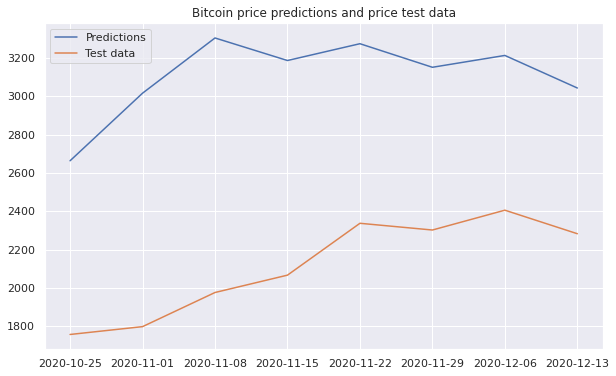

In [208]:
X_train_columns = ['IssContNtv']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.9981747970271341
Explained variance: 0.9981747970271341
MAE: 636.6354841523566
MSE: 1138639.7889087005
RMSE: 1067.0706578801146
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


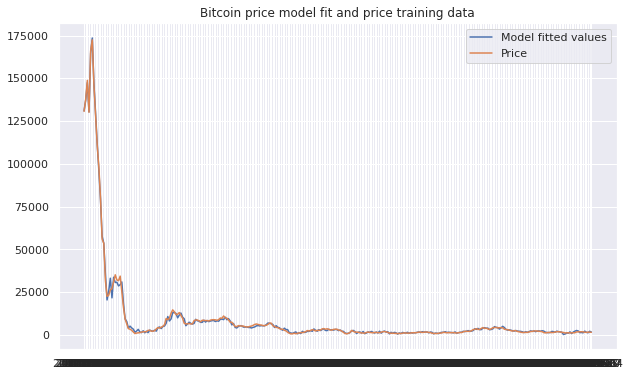

--------------------------------------------
model max lags: 16
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:33:02
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    24.7695
Nobs:                     310.000    HQIC:                   23.7060
Log likelihood:          -4737.25    FPE:                9.80035e+09
AIC:                      22.9977    Det(Omega_mle):     6.31021e+09
--------------------------------------------------------------------
Results for equation TxTfrValMeanNtv
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -4.700059         8.471833           -0.555           0.579
L1.TxTfrValMeanNtv          0.541872         0.06

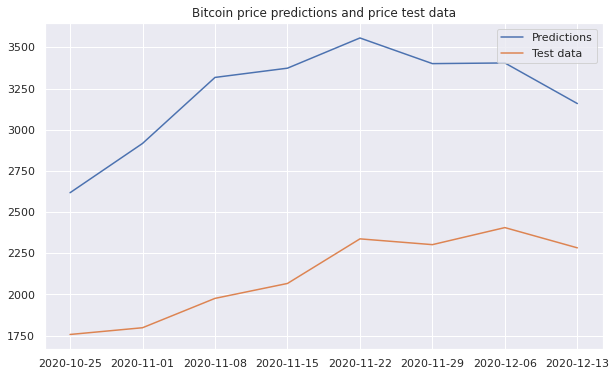

In [209]:
X_train_columns = ['TxTfrValMeanNtv', 'IssTotNtv']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.9979690622578978
Explained variance: 0.9979690622578978
MAE: 599.486510806644
MSE: 1266985.949690246
RMSE: 1125.604704010358
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


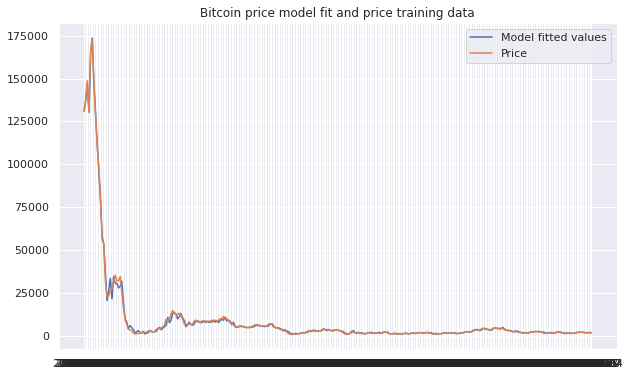

--------------------------------------------
model max lags: 16
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:33:13
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    20.4457
Nobs:                     310.000    HQIC:                   19.9682
Log likelihood:          -3859.52    FPE:                3.42497e+08
AIC:                      19.6502    Det(Omega_mle):     2.79764e+08
--------------------------------------------------------------------
Results for equation TxTfrValMeanNtv
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -9.840055         4.425420           -2.224           0.026
L1.TxTfrValMeanNtv          0.528260         0.06

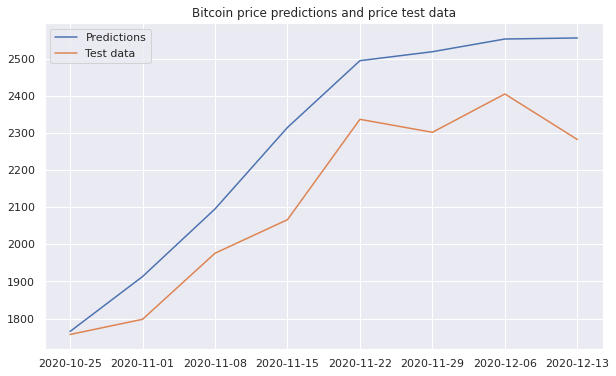

In [210]:
X_train_columns = ['TxTfrValMeanNtv']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.9984842837205817
Explained variance: 0.9984842837205817
MAE: 558.9436518987811
MSE: 945568.7340528399
RMSE: 972.4035859934083
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


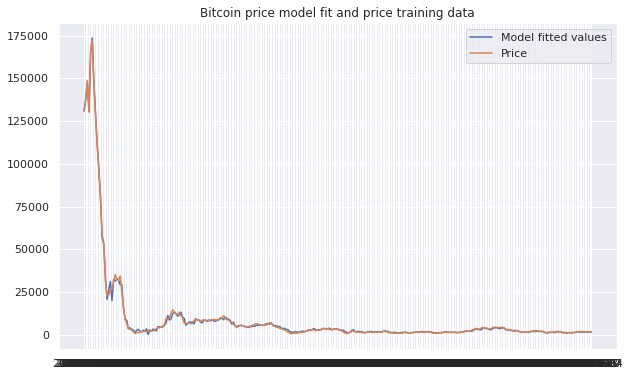

--------------------------------------------
model max lags: 16
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:33:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.68246
Nobs:                     310.000    HQIC:                   9.20496
Log likelihood:          -2191.22    FPE:                    7248.54
AIC:                      8.88694    Det(Omega_mle):         5920.88
--------------------------------------------------------------------
Results for equation SplyCur
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.008869         0.013736            0.646           0.518
L1.SplyCur           1.823390         0.055593           32.799           0.00

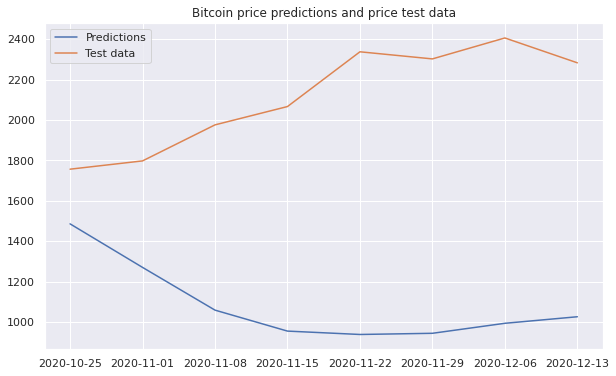

In [211]:
X_train_columns = ['SplyCur']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.9980841133381952
Explained variance: 0.9980841133381952
MAE: 639.4096464675922
MSE: 1195212.1581003922
RMSE: 1093.2575900035602
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


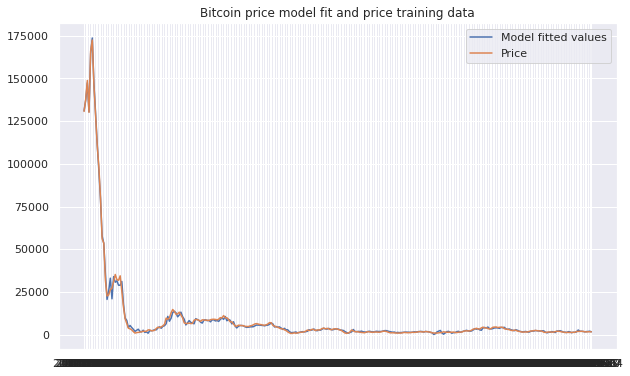

--------------------------------------------
model max lags: 16
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:33:35
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    12.2757
Nobs:                     310.000    HQIC:                   11.7982
Log likelihood:          -2593.16    FPE:                    96932.3
AIC:                      11.4801    Det(Omega_mle):         79177.9
--------------------------------------------------------------------
Results for equation SplyFF
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.063727         0.028425            2.242           0.025
L1.SplyFF            1.295359         0.059462           21.785           0.000

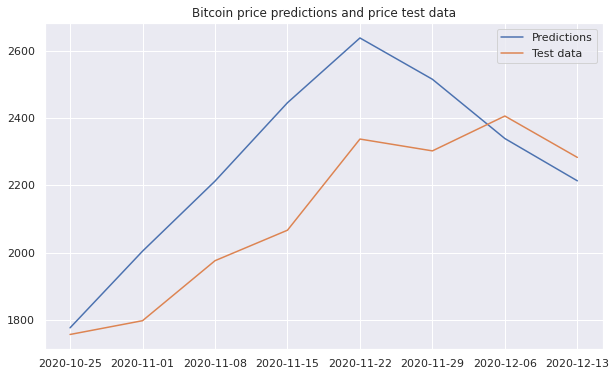

In [212]:
X_train_columns = ['SplyFF']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.998132970972187
Explained variance: 0.998132970972187
MAE: 639.6230710745658
MSE: 1164732.673417367
RMSE: 1079.2278134932249
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


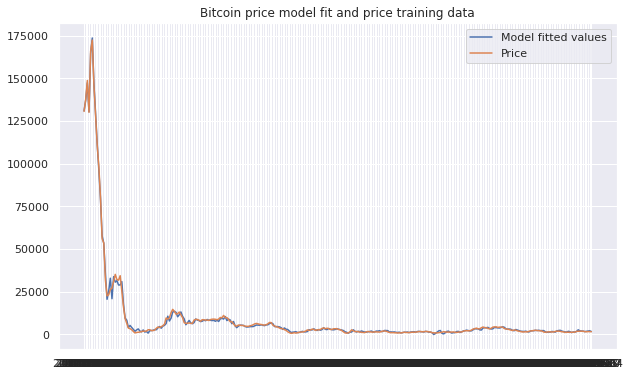

--------------------------------------------
model max lags: 16
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:33:46
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    18.8129
Nobs:                     310.000    HQIC:                   17.7493
Log likelihood:          -3813.97    FPE:                2.53689e+07
AIC:                      17.0410    Det(Omega_mle):     1.63344e+07
--------------------------------------------------------------------
Results for equation TxTfrValMeanNtv
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                     -15.981280         5.612800           -2.847           0.004
L1.TxTfrValMeanNtv          0.516039         0.06

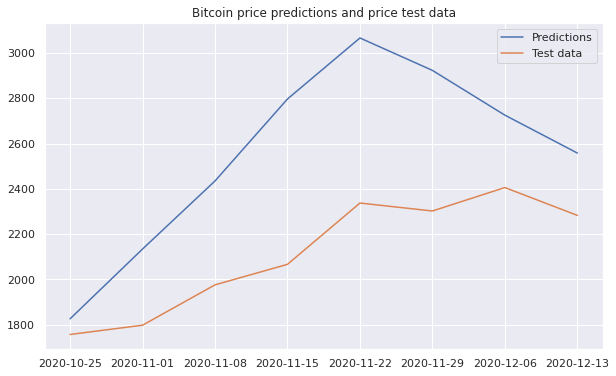

In [213]:
X_train_columns = ['TxTfrValMeanNtv', 'SplyFF']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.999390544752952
Explained variance: 0.999390544752952
MAE: 394.8927547816153
MSE: 380204.2864079166
RMSE: 616.6070761902726
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


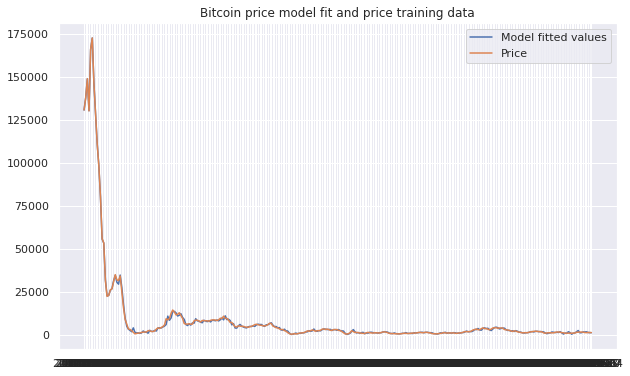

--------------------------------------------
model max lags: 16
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:33:58
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    43.3802
Nobs:                     310.000    HQIC:                   42.3166
Log likelihood:          -7621.90    FPE:                1.18508e+18
AIC:                      41.6083    Det(Omega_mle):     7.63042e+17
--------------------------------------------------------------------
Results for equation AdrActCnt2
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const              -6254.769381      4874.666464           -1.283           0.199
L1.AdrActCnt2          0.250685         0.046677            5.371    

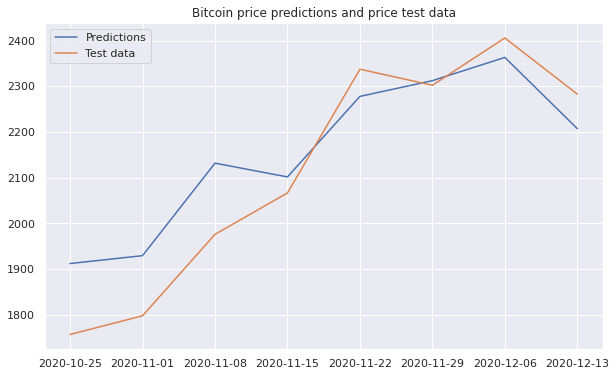

In [214]:
X_train_columns = ['AdrActCnt2', 'S2F']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD'))

--------------------------------------------
Training set scores
r2: 0.998200943772557
Explained variance: 0.998200943772557
MAE: 633.496774235497
MSE: 1122328.3292346303
RMSE: 1059.3999854798142
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


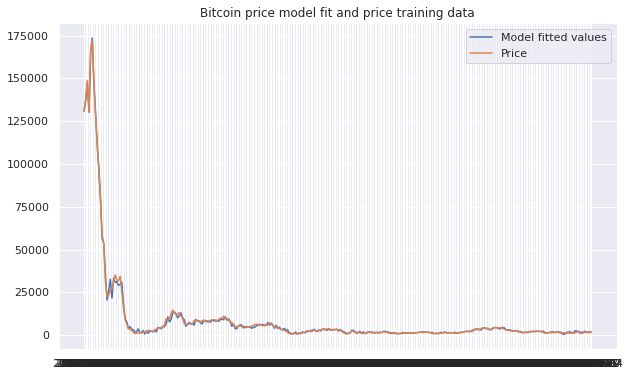

--------------------------------------------
model max lags: 16
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:34:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    22.6999
Nobs:                     310.000    HQIC:                   22.2224
Log likelihood:          -4208.91    FPE:                3.26316e+09
AIC:                      21.9043    Det(Omega_mle):     2.66547e+09
--------------------------------------------------------------------
Results for equation S2F
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               13.668713         7.032797            1.944           0.052
L1.S2F               0.913062         0.058839           15.518           0.000
L1

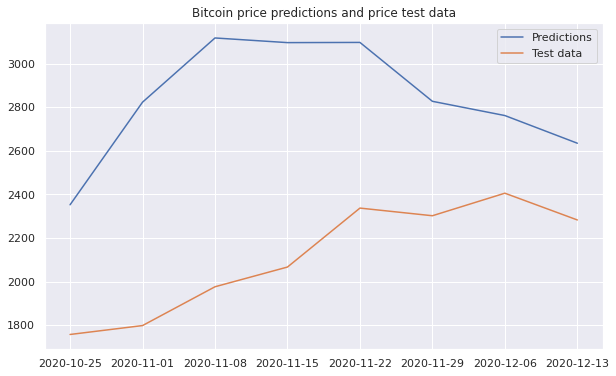

In [215]:
X_train_columns = ['S2F']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

print(train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD'))

<h1>Conclusions</h1>
<p>1. The best modeling results were reached using weekly transformed data. Each observation was transformed to represent the 4-year % change. The 4-year period was choosen because normally bitcoin prices move on a 4-year cycle that coincides with its supply growth halving (halving period)</p>
<p>2. The feature that gave the best testing scores for the model was the squared number of active addresses (AdrActCnt2), a proxy for users of the bitcoin network or usage. </p>
<p>3. Test scores using this feature were, r2: 0.91, explained variance: 0.91, MAE: 50.8, MSE: 5262, RMSE: 72.5 </p> 
<p>4. This model specification outperformed all other feature combinations that were tried.</p> 


--------------------------------------------
Training set scores
r2: 0.9992817049111591
Explained variance: 0.9992817049111591
MAE: 398.12182316605254
MSE: 448103.2413878922
RMSE: 669.4051399473209
--------------------------------------------


/home/julio/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


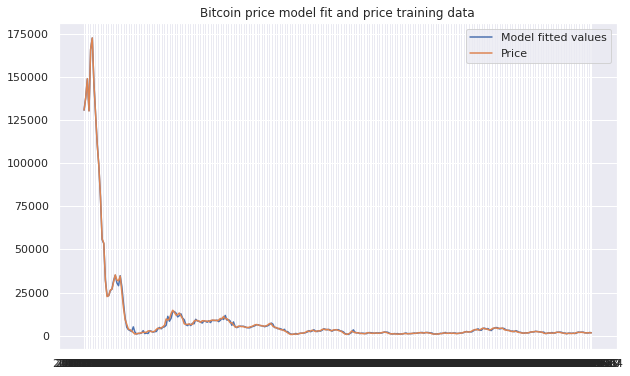

--------------------------------------------
model max lags: 16
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Feb, 2021
Time:                     17:34:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    34.8109
Nobs:                     310.000    HQIC:                   34.3334
Log likelihood:          -6086.12    FPE:                5.93452e+14
AIC:                      34.0154    Det(Omega_mle):     4.84753e+14
--------------------------------------------------------------------
Results for equation AdrActCnt2
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const             -12169.564302      3411.090647           -3.568           0.000
L1.AdrActCnt2          0.290011         0.043707            6.635    

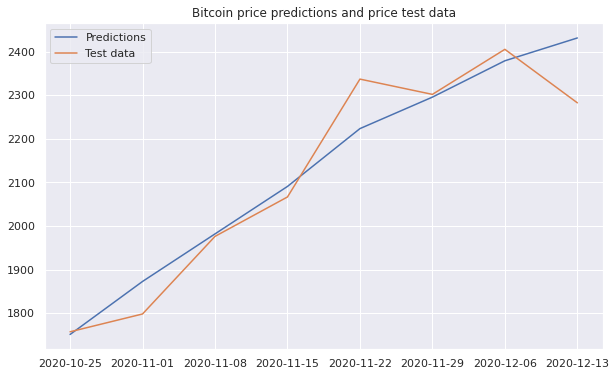

In [216]:
#Calculating scores with the holdout set.

#Running the model again with the training set
X_train_columns = ['AdrActCnt2']
X_train_to_model = X_train[X_train_columns]
train_df = pd.concat([X_train_to_model, y_train], axis=1)

results = train_test_model(train_df, y_test, 'aic', 'c', 'PriceUSD')


--------------------------------------------
Holdout set scores
r2: -0.2441584162843058
Explained variance: -0.09766692779781416
MAE: 495.3427528413425
MSE: 336857.4098293986
RMSE: 580.3941848686965


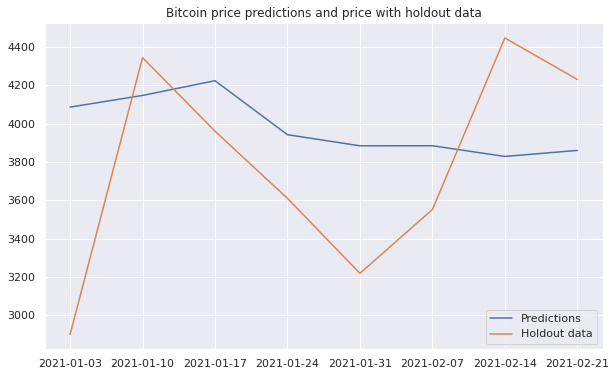

In [217]:
#Model prediction with holdout set.
#print(results.k_ar)

holdout_df = weekly_pct4[['AdrActCnt2', 'PriceUSD']].iloc[-results.k_ar:]
#print(holdout_df)

steps = len(X_hold)
#print(steps)

y_pred = results.forecast(y = holdout_df.values[-results.k_ar:], steps=steps)
#print(y_pred)

PriceUSD_pred = y_pred[:,len(holdout_df.columns) - 1] 
#print(PriceUSD_pred)

y_hold = holdout_df['PriceUSD'].iloc[-8:]
#print(y_hold)


#Testing scores
#r squared
r2_hold = r2_score(y_hold, PriceUSD_pred)
#explained variance
expl_var_hold = explained_variance_score(y_hold, PriceUSD_pred)
#MAE
mae_hold = mean_absolute_error(y_hold, PriceUSD_pred)
#MSE
mse_hold = mean_squared_error(y_hold, PriceUSD_pred)
#RMSE
rmse_hold = np.sqrt(mse_hold)

print('--------------------------------------------')
print('Holdout set scores')
print('r2: {}'.format(r2_hold))
print('Explained variance: {}'.format(expl_var_hold))
print('MAE: {}'.format(mae_hold))
print('MSE: {}'.format(mse_hold))
print('RMSE: {}'.format(rmse_hold))

#Plot test and prediction
plt.figure(figsize=(10,6))
plt.plot(PriceUSD_pred, label='Predictions')
plt.plot(y_hold, label='Holdout data')
plt.title('Bitcoin price predictions and price with holdout data')
plt.legend(loc='best')
plt.show()



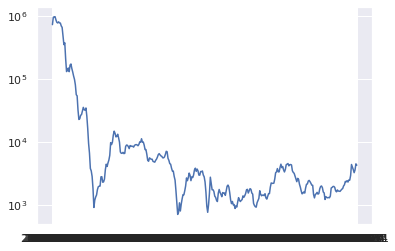

697.5237224788333


In [218]:
plt.plot(weekly_pct4['PriceUSD'])
plt.yscale('log')
plt.show()
print(np.min(weekly_pct4['PriceUSD']))